# Vanilla GAN —— Min-MAX GAN
MMGAN指的是通过 $\log(1-D(x))$，即优化Jason-Shannon散度的GAN

顺手实现一下ONE SIDE Softlabel吧！
# Import Necessary Packages

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image 

import matplotlib.pyplot as plt
# Enable Jupyter notebook plotting
%matplotlib inline
from itertools import product # draw 10 * 10 images

from tqdm import tqdm

# Pytorch Version
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


# Hyper Parameters

In [2]:
batch_size = 128
num_epoch = 200
z_dimension = 100 # size of input noise
lr_G = 1e-4
lr_D = 1e-4 # leanring rate of Generator and Discriminator
softlabel = 0.1 # can't be lager than 0.5!

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Datasets files & utils

In [3]:
# the path we save data
if not os.path.exists('../../img'):
    os.mkdir('../../img')

# Transform of our datasets
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5), std = (0.5))
])
    
# MNIST datasets downloading……
mnist = datasets.MNIST(
    root = '../../data/mnist/', train = True, transform = trans, download = True
)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset = mnist, batch_size = batch_size, shuffle = True
)


In [4]:
def to_gray_img(x):
    out = 0.5*(x+1)
    out = out.clamp(0,1) # force therandom distribution of x into [min, max]
    out = out.view(-1, 1, 28, 28) # view a multi-row Tensor as one row
    return out

# Discriminator Definitions (Vanilla FC Fashion)
Considering that the MNIST images are all of 28 * 28 images, the input size of our fully connection network is 784.

It is a **unconditional** version.

In [5]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__() # 说起来这句是干嘛的？
        self.D = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() # propability of the given image being Real
        )
    
    def forward(self, x):
        x = self.D(x)
        return x

# Generator Definitions (Vanilla FC Fashion)
Considering that the MNIST images are all of 28 * 28 images, the output size of our fully connection network is 784.

The final `Tanh` activataion function can project output into (-1,1)

It is a **unconditional** version.

In [6]:
class generator(nn.Module):
    
    def __init__(self):
        super(generator, self).__init__()
        self.G = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.G(x)
        return x
        
        

# Traning Phase
## Model & Opitmizer

In [7]:

D = discriminator()
G = generator()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = D.to(device)
G = G.to(device)




### MMGAN与NSGAN的不同
**NSGAN**不论是 $G$ 还是 $D$ 的实现都可以直接用二分类交叉熵实现。
而**MMGAN**则不行，不论是 $G$ 还是 $D$ 的损失函数需要手动写（虽然也很简单就是了）
$$\tilde{V}=\frac{1}{m} \sum_{i=1}^{m} \log D\left(x^{i}\right)+\frac{1}{m} \sum_{i=1}^{m} \log \left(1-D\left(\tilde{x}^{i}\right)\right)$$


In [8]:
# criterion = nn.BCELoss() # 二分类交叉熵

d_optimizer = torch.optim.Adam(D.parameters(), lr = lr_D)
g_optimizer = torch.optim.Adam(G.parameters(), lr = lr_G)

## Trainning Start!

  0%|          | 0/200 [00:00<?, ?it/s]

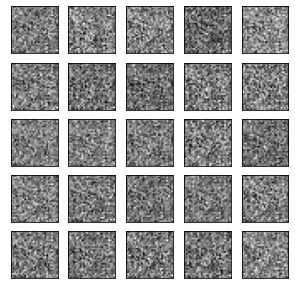

Epoch[0/200],d_loss:1.013358,g_loss:0.436249 D real: 0.793528,D fake: 0.430689
Epoch[0/200],d_loss:0.486855,g_loss:0.893533 D real: 0.884932,D fake: 0.100617
Epoch[0/200],d_loss:0.458848,g_loss:0.906565 D real: 0.887614,D fake: 0.088454
Epoch[0/200],d_loss:0.473117,g_loss:0.892700 D real: 0.887340,D fake: 0.101414


  0%|          | 1/200 [00:40<2:13:28, 40.24s/it]

Epoch[1/200],d_loss:0.374425,g_loss:0.980701 D real: 0.891040,D fake: 0.019070
Epoch[1/200],d_loss:0.344857,g_loss:0.989433 D real: 0.894876,D fake: 0.010501
Epoch[1/200],d_loss:0.352998,g_loss:0.982124 D real: 0.890702,D fake: 0.017674
Epoch[1/200],d_loss:0.544872,g_loss:0.904183 D real: 0.845931,D fake: 0.091198


  1%|          | 2/200 [01:12<2:05:02, 37.89s/it]

Epoch[2/200],d_loss:0.424260,g_loss:0.962126 D real: 0.907945,D fake: 0.037014
Epoch[2/200],d_loss:0.357162,g_loss:0.986807 D real: 0.869439,D fake: 0.013086
Epoch[2/200],d_loss:0.364226,g_loss:0.985851 D real: 0.873902,D fake: 0.014032
Epoch[2/200],d_loss:0.362451,g_loss:0.999565 D real: 0.920754,D fake: 0.000435


  2%|▏         | 3/200 [01:45<1:59:39, 36.44s/it]

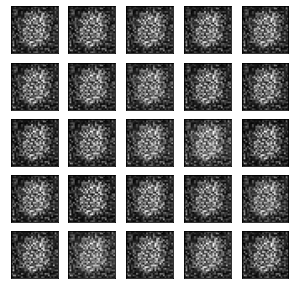

Epoch[3/200],d_loss:0.335798,g_loss:0.999111 D real: 0.888898,D fake: 0.000889
Epoch[3/200],d_loss:0.333762,g_loss:0.998600 D real: 0.906876,D fake: 0.001398
Epoch[3/200],d_loss:0.332238,g_loss:0.998171 D real: 0.895129,D fake: 0.001826
Epoch[3/200],d_loss:0.339682,g_loss:0.990356 D real: 0.900483,D fake: 0.009573


  2%|▏         | 4/200 [02:21<1:58:24, 36.25s/it]

Epoch[4/200],d_loss:0.404660,g_loss:0.982517 D real: 0.918073,D fake: 0.017180
Epoch[4/200],d_loss:0.373759,g_loss:0.981655 D real: 0.896764,D fake: 0.018135
Epoch[4/200],d_loss:0.353816,g_loss:0.996866 D real: 0.878303,D fake: 0.003128
Epoch[4/200],d_loss:0.366395,g_loss:0.991485 D real: 0.857381,D fake: 0.008473


  2%|▎         | 5/200 [02:53<1:53:57, 35.06s/it]

Epoch[5/200],d_loss:0.347653,g_loss:0.997388 D real: 0.912350,D fake: 0.002606
Epoch[5/200],d_loss:0.438237,g_loss:0.961649 D real: 0.836482,D fake: 0.036833
Epoch[5/200],d_loss:0.389844,g_loss:0.994350 D real: 0.853291,D fake: 0.005604
Epoch[5/200],d_loss:0.371022,g_loss:0.984404 D real: 0.875380,D fake: 0.015396


  3%|▎         | 6/200 [03:26<1:50:35, 34.20s/it]

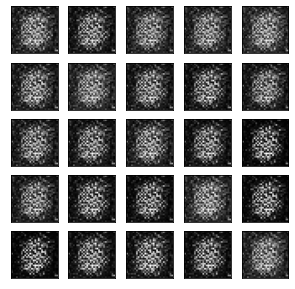

Epoch[6/200],d_loss:0.348235,g_loss:0.999842 D real: 0.913242,D fake: 0.000158
Epoch[6/200],d_loss:0.346800,g_loss:0.999627 D real: 0.916934,D fake: 0.000373
Epoch[6/200],d_loss:0.335774,g_loss:0.999583 D real: 0.907988,D fake: 0.000417
Epoch[6/200],d_loss:0.333313,g_loss:0.999503 D real: 0.896245,D fake: 0.000496


  4%|▎         | 7/200 [04:01<1:51:19, 34.61s/it]

Epoch[7/200],d_loss:0.332630,g_loss:0.999198 D real: 0.900154,D fake: 0.000801
Epoch[7/200],d_loss:0.332564,g_loss:0.998667 D real: 0.897088,D fake: 0.001332
Epoch[7/200],d_loss:0.925590,g_loss:0.863122 D real: 0.750273,D fake: 0.109191
Epoch[7/200],d_loss:0.351997,g_loss:0.999771 D real: 0.912521,D fake: 0.000229


  4%|▍         | 8/200 [04:33<1:48:04, 33.77s/it]

Epoch[8/200],d_loss:0.339277,g_loss:0.999002 D real: 0.898034,D fake: 0.000997
Epoch[8/200],d_loss:0.392802,g_loss:0.991710 D real: 0.900211,D fake: 0.007966
Epoch[8/200],d_loss:1.108153,g_loss:0.860960 D real: 0.749555,D fake: 0.112342
Epoch[8/200],d_loss:0.352544,g_loss:0.999524 D real: 0.881897,D fake: 0.000475


  4%|▍         | 9/200 [05:07<1:47:51, 33.88s/it]

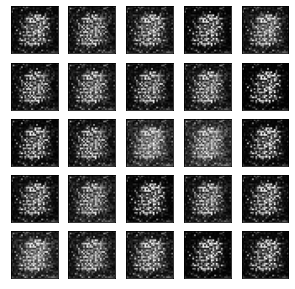

Epoch[9/200],d_loss:0.338348,g_loss:0.998820 D real: 0.911065,D fake: 0.001178
Epoch[9/200],d_loss:0.334856,g_loss:0.998844 D real: 0.902235,D fake: 0.001155
Epoch[9/200],d_loss:0.340961,g_loss:0.996324 D real: 0.893228,D fake: 0.003659
Epoch[9/200],d_loss:0.364352,g_loss:0.995914 D real: 0.897436,D fake: 0.004067


  5%|▌         | 10/200 [05:41<1:47:46, 34.03s/it]

Epoch[10/200],d_loss:0.411476,g_loss:0.963990 D real: 0.867790,D fake: 0.034772
Epoch[10/200],d_loss:0.362218,g_loss:0.998793 D real: 0.895020,D fake: 0.001205
Epoch[10/200],d_loss:0.347505,g_loss:0.995902 D real: 0.889666,D fake: 0.004077
Epoch[10/200],d_loss:0.404005,g_loss:0.980648 D real: 0.875789,D fake: 0.018784


  6%|▌         | 11/200 [06:16<1:47:36, 34.16s/it]

Epoch[11/200],d_loss:0.503271,g_loss:0.956122 D real: 0.814281,D fake: 0.041989
Epoch[11/200],d_loss:0.363469,g_loss:0.988056 D real: 0.895082,D fake: 0.011790
Epoch[11/200],d_loss:0.374456,g_loss:0.993970 D real: 0.900707,D fake: 0.005992
Epoch[11/200],d_loss:0.737793,g_loss:0.800896 D real: 0.654833,D fake: 0.166563


  6%|▌         | 12/200 [06:49<1:45:41, 33.73s/it]

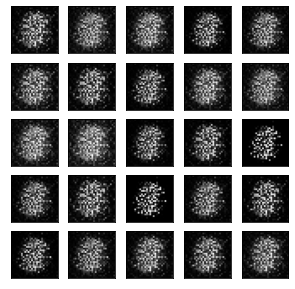

Epoch[12/200],d_loss:0.404428,g_loss:0.976406 D real: 0.853184,D fake: 0.023066
Epoch[12/200],d_loss:0.393645,g_loss:0.988052 D real: 0.909063,D fake: 0.011797
Epoch[12/200],d_loss:0.437434,g_loss:0.970527 D real: 0.872390,D fake: 0.028520
Epoch[12/200],d_loss:0.370318,g_loss:0.999608 D real: 0.891554,D fake: 0.000392


  6%|▋         | 13/200 [07:25<1:47:44, 34.57s/it]

Epoch[13/200],d_loss:0.345794,g_loss:0.998639 D real: 0.895835,D fake: 0.001358
Epoch[13/200],d_loss:0.341026,g_loss:0.998278 D real: 0.898315,D fake: 0.001718
Epoch[13/200],d_loss:0.338608,g_loss:0.997779 D real: 0.891901,D fake: 0.002214
Epoch[13/200],d_loss:0.338893,g_loss:0.996381 D real: 0.893647,D fake: 0.003601


  7%|▋         | 14/200 [07:59<1:46:16, 34.28s/it]

Epoch[14/200],d_loss:0.409301,g_loss:0.983745 D real: 0.844523,D fake: 0.015997
Epoch[14/200],d_loss:0.462493,g_loss:0.976307 D real: 0.918333,D fake: 0.023304
Epoch[14/200],d_loss:0.368570,g_loss:0.988024 D real: 0.891308,D fake: 0.011873
Epoch[14/200],d_loss:0.425379,g_loss:0.980335 D real: 0.907799,D fake: 0.019133


  8%|▊         | 15/200 [08:32<1:45:08, 34.10s/it]

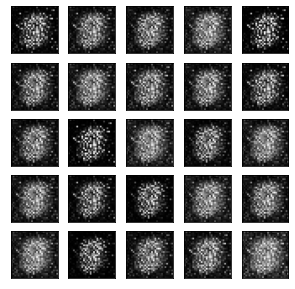

Epoch[15/200],d_loss:0.451441,g_loss:0.955778 D real: 0.860620,D fake: 0.042432
Epoch[15/200],d_loss:0.415240,g_loss:0.977039 D real: 0.867515,D fake: 0.022126
Epoch[15/200],d_loss:0.524878,g_loss:0.922591 D real: 0.853428,D fake: 0.065572
Epoch[15/200],d_loss:0.459474,g_loss:0.952776 D real: 0.837246,D fake: 0.045165


  8%|▊         | 16/200 [09:07<1:45:14, 34.32s/it]

Epoch[16/200],d_loss:0.378328,g_loss:0.998056 D real: 0.900434,D fake: 0.001940
Epoch[16/200],d_loss:0.356621,g_loss:0.996169 D real: 0.889518,D fake: 0.003818
Epoch[16/200],d_loss:0.361478,g_loss:0.993815 D real: 0.884237,D fake: 0.006147
Epoch[16/200],d_loss:0.392659,g_loss:0.954406 D real: 0.862635,D fake: 0.043320


  8%|▊         | 17/200 [09:43<1:46:07, 34.80s/it]

Epoch[17/200],d_loss:0.628710,g_loss:0.900733 D real: 0.707073,D fake: 0.090984
Epoch[17/200],d_loss:0.798867,g_loss:0.809887 D real: 0.832112,D fake: 0.146477
Epoch[17/200],d_loss:0.452415,g_loss:0.942877 D real: 0.897913,D fake: 0.053355
Epoch[17/200],d_loss:0.539116,g_loss:0.919715 D real: 0.759999,D fake: 0.074572


  9%|▉         | 18/200 [10:18<1:45:18, 34.72s/it]

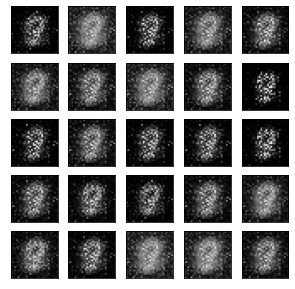

Epoch[18/200],d_loss:0.523509,g_loss:0.957636 D real: 0.832165,D fake: 0.041267
Epoch[18/200],d_loss:0.494086,g_loss:0.963722 D real: 0.799983,D fake: 0.034681
Epoch[18/200],d_loss:0.494257,g_loss:0.949872 D real: 0.826946,D fake: 0.048227
Epoch[18/200],d_loss:0.491343,g_loss:0.944131 D real: 0.910428,D fake: 0.053843


 10%|▉         | 19/200 [10:56<1:47:46, 35.73s/it]

Epoch[19/200],d_loss:0.402887,g_loss:0.970730 D real: 0.889181,D fake: 0.028622
Epoch[19/200],d_loss:0.416810,g_loss:0.965565 D real: 0.863754,D fake: 0.033067
Epoch[19/200],d_loss:0.559984,g_loss:0.882411 D real: 0.853717,D fake: 0.106467
Epoch[19/200],d_loss:0.365377,g_loss:0.994587 D real: 0.895494,D fake: 0.005394


 10%|█         | 20/200 [11:27<1:43:29, 34.50s/it]

Epoch[20/200],d_loss:0.415768,g_loss:0.963743 D real: 0.889790,D fake: 0.035205
Epoch[20/200],d_loss:0.456713,g_loss:0.972393 D real: 0.850040,D fake: 0.027166
Epoch[20/200],d_loss:0.391941,g_loss:0.976752 D real: 0.882272,D fake: 0.022914
Epoch[20/200],d_loss:0.398974,g_loss:0.974740 D real: 0.900675,D fake: 0.024853


 10%|█         | 21/200 [12:01<1:42:19, 34.30s/it]

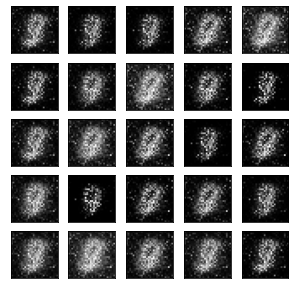

Epoch[21/200],d_loss:0.440610,g_loss:0.970071 D real: 0.848874,D fake: 0.029235
Epoch[21/200],d_loss:0.463944,g_loss:0.938104 D real: 0.854691,D fake: 0.059141
Epoch[21/200],d_loss:0.455162,g_loss:0.962203 D real: 0.880899,D fake: 0.036128
Epoch[21/200],d_loss:0.469408,g_loss:0.926694 D real: 0.817083,D fake: 0.068493


 11%|█         | 22/200 [12:36<1:42:24, 34.52s/it]

Epoch[22/200],d_loss:0.373363,g_loss:0.990495 D real: 0.887659,D fake: 0.009433
Epoch[22/200],d_loss:0.437840,g_loss:0.961568 D real: 0.903753,D fake: 0.036994
Epoch[22/200],d_loss:0.514421,g_loss:0.941809 D real: 0.882248,D fake: 0.054869
Epoch[22/200],d_loss:0.465963,g_loss:0.967308 D real: 0.828180,D fake: 0.031105


 12%|█▏        | 23/200 [13:09<1:40:21, 34.02s/it]

Epoch[23/200],d_loss:0.476548,g_loss:0.961822 D real: 0.818299,D fake: 0.037288
Epoch[23/200],d_loss:0.561676,g_loss:0.939120 D real: 0.808217,D fake: 0.055132
Epoch[23/200],d_loss:0.475185,g_loss:0.962498 D real: 0.867360,D fake: 0.036576
Epoch[23/200],d_loss:0.404110,g_loss:0.987535 D real: 0.877156,D fake: 0.012368


 12%|█▏        | 24/200 [13:41<1:38:07, 33.45s/it]

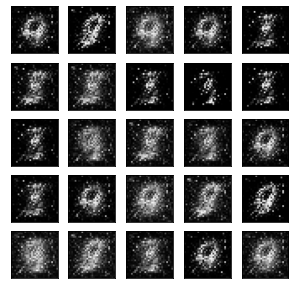

Epoch[24/200],d_loss:0.495732,g_loss:0.958561 D real: 0.854878,D fake: 0.040160
Epoch[24/200],d_loss:0.386260,g_loss:0.982553 D real: 0.880844,D fake: 0.017053
Epoch[24/200],d_loss:0.551105,g_loss:0.934125 D real: 0.784043,D fake: 0.061091
Epoch[24/200],d_loss:0.425585,g_loss:0.982051 D real: 0.859242,D fake: 0.017591


 12%|█▎        | 25/200 [14:15<1:37:42, 33.50s/it]

Epoch[25/200],d_loss:0.432638,g_loss:0.988768 D real: 0.876003,D fake: 0.011089
Epoch[25/200],d_loss:0.433078,g_loss:0.981538 D real: 0.878124,D fake: 0.018185
Epoch[25/200],d_loss:0.473908,g_loss:0.953826 D real: 0.838609,D fake: 0.044634
Epoch[25/200],d_loss:0.386403,g_loss:0.984775 D real: 0.895587,D fake: 0.014940


 13%|█▎        | 26/200 [14:49<1:37:47, 33.72s/it]

Epoch[26/200],d_loss:0.474313,g_loss:0.970083 D real: 0.836437,D fake: 0.029299
Epoch[26/200],d_loss:0.429585,g_loss:0.981852 D real: 0.932416,D fake: 0.017859
Epoch[26/200],d_loss:0.382558,g_loss:0.990075 D real: 0.884752,D fake: 0.009852
Epoch[26/200],d_loss:0.445192,g_loss:0.977499 D real: 0.902056,D fake: 0.022127


 14%|█▎        | 27/200 [15:23<1:37:00, 33.65s/it]

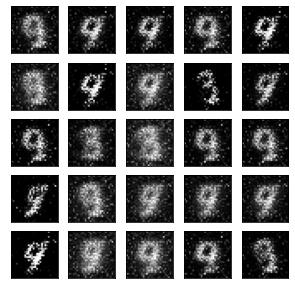

Epoch[27/200],d_loss:0.431029,g_loss:0.968527 D real: 0.917279,D fake: 0.030105
Epoch[27/200],d_loss:0.390774,g_loss:0.987901 D real: 0.863992,D fake: 0.011996
Epoch[27/200],d_loss:0.435364,g_loss:0.968196 D real: 0.890634,D fake: 0.031064
Epoch[27/200],d_loss:0.412395,g_loss:0.973999 D real: 0.856267,D fake: 0.025312


 14%|█▍        | 28/200 [15:59<1:38:51, 34.49s/it]

Epoch[28/200],d_loss:0.417847,g_loss:0.991593 D real: 0.824313,D fake: 0.008334
Epoch[28/200],d_loss:0.424842,g_loss:0.973193 D real: 0.896361,D fake: 0.026299
Epoch[28/200],d_loss:0.397619,g_loss:0.977335 D real: 0.878580,D fake: 0.022251
Epoch[28/200],d_loss:0.587334,g_loss:0.962658 D real: 0.881539,D fake: 0.036337


 14%|█▍        | 29/200 [16:33<1:37:54, 34.36s/it]

Epoch[29/200],d_loss:0.390362,g_loss:0.973689 D real: 0.886172,D fake: 0.025338
Epoch[29/200],d_loss:0.432450,g_loss:0.977442 D real: 0.846707,D fake: 0.022073
Epoch[29/200],d_loss:0.459610,g_loss:0.958679 D real: 0.813006,D fake: 0.039898
Epoch[29/200],d_loss:0.379283,g_loss:0.984200 D real: 0.892364,D fake: 0.015588


 15%|█▌        | 30/200 [17:06<1:35:54, 33.85s/it]

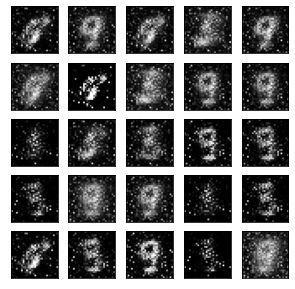

Epoch[30/200],d_loss:0.380414,g_loss:0.985283 D real: 0.895871,D fake: 0.014520
Epoch[30/200],d_loss:0.480764,g_loss:0.951864 D real: 0.836265,D fake: 0.045657
Epoch[30/200],d_loss:0.522193,g_loss:0.976562 D real: 0.836774,D fake: 0.022936
Epoch[30/200],d_loss:0.396933,g_loss:0.968597 D real: 0.882252,D fake: 0.030413


 16%|█▌        | 31/200 [17:40<1:35:41, 33.97s/it]

Epoch[31/200],d_loss:0.393859,g_loss:0.984004 D real: 0.879093,D fake: 0.015532
Epoch[31/200],d_loss:0.380711,g_loss:0.987446 D real: 0.877918,D fake: 0.012036
Epoch[31/200],d_loss:0.439013,g_loss:0.967995 D real: 0.848580,D fake: 0.030977
Epoch[31/200],d_loss:0.435227,g_loss:0.962453 D real: 0.917446,D fake: 0.035819


 16%|█▌        | 32/200 [18:13<1:34:12, 33.65s/it]

Epoch[32/200],d_loss:0.458284,g_loss:0.978930 D real: 0.855093,D fake: 0.020491
Epoch[32/200],d_loss:0.393374,g_loss:0.980262 D real: 0.890709,D fake: 0.019287
Epoch[32/200],d_loss:0.374436,g_loss:0.986599 D real: 0.873794,D fake: 0.013110
Epoch[32/200],d_loss:0.385794,g_loss:0.990324 D real: 0.901026,D fake: 0.009538


 16%|█▋        | 33/200 [18:47<1:33:56, 33.75s/it]

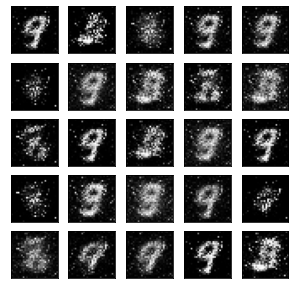

Epoch[33/200],d_loss:0.401685,g_loss:0.991964 D real: 0.856435,D fake: 0.007975
Epoch[33/200],d_loss:0.461988,g_loss:0.955087 D real: 0.858384,D fake: 0.043018
Epoch[33/200],d_loss:0.406447,g_loss:0.968351 D real: 0.882965,D fake: 0.030509
Epoch[33/200],d_loss:0.384002,g_loss:0.967169 D real: 0.906084,D fake: 0.031630


 17%|█▋        | 34/200 [19:25<1:37:12, 35.14s/it]

Epoch[34/200],d_loss:0.393430,g_loss:0.985594 D real: 0.856861,D fake: 0.014234
Epoch[34/200],d_loss:0.368306,g_loss:0.994043 D real: 0.882010,D fake: 0.005897
Epoch[34/200],d_loss:0.411685,g_loss:0.983199 D real: 0.846268,D fake: 0.015979
Epoch[34/200],d_loss:0.463315,g_loss:0.984689 D real: 0.836926,D fake: 0.015038


 18%|█▊        | 35/200 [20:02<1:37:36, 35.49s/it]

Epoch[35/200],d_loss:0.443642,g_loss:0.965390 D real: 0.846152,D fake: 0.033120
Epoch[35/200],d_loss:0.413433,g_loss:0.961682 D real: 0.861842,D fake: 0.036768
Epoch[35/200],d_loss:0.398016,g_loss:0.985725 D real: 0.871930,D fake: 0.014072
Epoch[35/200],d_loss:0.376742,g_loss:0.991120 D real: 0.861235,D fake: 0.008809


 18%|█▊        | 36/200 [20:34<1:34:39, 34.63s/it]

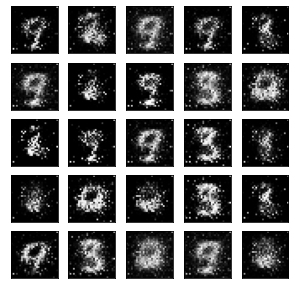

Epoch[36/200],d_loss:0.355893,g_loss:0.995052 D real: 0.896480,D fake: 0.004909
Epoch[36/200],d_loss:0.405867,g_loss:0.991834 D real: 0.833278,D fake: 0.008095
Epoch[36/200],d_loss:0.360381,g_loss:0.989857 D real: 0.901296,D fake: 0.010009
Epoch[36/200],d_loss:0.394126,g_loss:0.996981 D real: 0.863883,D fake: 0.003001


 18%|█▊        | 37/200 [21:10<1:35:11, 35.04s/it]

Epoch[37/200],d_loss:0.390465,g_loss:0.987285 D real: 0.849522,D fake: 0.012539
Epoch[37/200],d_loss:0.424731,g_loss:0.983091 D real: 0.831305,D fake: 0.016405
Epoch[37/200],d_loss:0.451416,g_loss:0.962633 D real: 0.887726,D fake: 0.036128
Epoch[37/200],d_loss:0.399750,g_loss:0.990908 D real: 0.855246,D fake: 0.008946


 19%|█▉        | 38/200 [21:44<1:33:39, 34.69s/it]

Epoch[38/200],d_loss:0.396931,g_loss:0.980970 D real: 0.861528,D fake: 0.018293
Epoch[38/200],d_loss:0.499483,g_loss:0.989288 D real: 0.784394,D fake: 0.010286
Epoch[38/200],d_loss:0.415563,g_loss:0.952113 D real: 0.885400,D fake: 0.044629
Epoch[38/200],d_loss:0.373874,g_loss:0.992338 D real: 0.880418,D fake: 0.007539


 20%|█▉        | 39/200 [22:19<1:33:33, 34.87s/it]

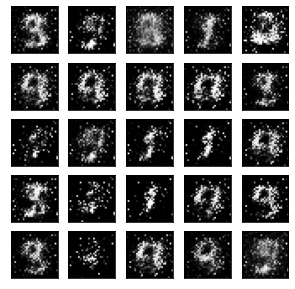

Epoch[39/200],d_loss:0.416401,g_loss:0.975415 D real: 0.861651,D fake: 0.023133
Epoch[39/200],d_loss:0.413798,g_loss:0.993562 D real: 0.859690,D fake: 0.006275
Epoch[39/200],d_loss:0.392691,g_loss:0.991908 D real: 0.850311,D fake: 0.007346
Epoch[39/200],d_loss:0.403400,g_loss:0.975990 D real: 0.910118,D fake: 0.023059


 20%|██        | 40/200 [22:53<1:31:59, 34.50s/it]

Epoch[40/200],d_loss:0.386831,g_loss:0.992258 D real: 0.852706,D fake: 0.007643
Epoch[40/200],d_loss:0.352586,g_loss:0.993803 D real: 0.904467,D fake: 0.006087
Epoch[40/200],d_loss:0.385441,g_loss:0.989604 D real: 0.869341,D fake: 0.010118
Epoch[40/200],d_loss:0.375964,g_loss:0.989604 D real: 0.883322,D fake: 0.010164


 20%|██        | 41/200 [23:28<1:31:54, 34.68s/it]

Epoch[41/200],d_loss:0.409750,g_loss:0.988507 D real: 0.850379,D fake: 0.011320
Epoch[41/200],d_loss:0.377095,g_loss:0.976242 D real: 0.889223,D fake: 0.022790
Epoch[41/200],d_loss:0.398439,g_loss:0.964186 D real: 0.891154,D fake: 0.033420
Epoch[41/200],d_loss:0.415025,g_loss:0.968894 D real: 0.873347,D fake: 0.029722


 21%|██        | 42/200 [24:01<1:29:47, 34.10s/it]

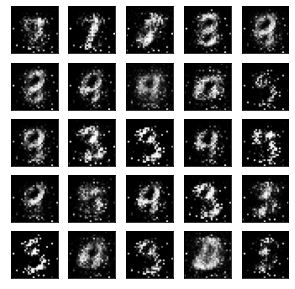

Epoch[42/200],d_loss:0.385602,g_loss:0.987851 D real: 0.897511,D fake: 0.011936
Epoch[42/200],d_loss:0.374406,g_loss:0.972294 D real: 0.904752,D fake: 0.026586
Epoch[42/200],d_loss:0.404430,g_loss:0.973668 D real: 0.884528,D fake: 0.025097
Epoch[42/200],d_loss:0.398974,g_loss:0.984832 D real: 0.902681,D fake: 0.014496


 22%|██▏       | 43/200 [24:35<1:29:10, 34.08s/it]

Epoch[43/200],d_loss:0.449068,g_loss:0.962733 D real: 0.876766,D fake: 0.034495
Epoch[43/200],d_loss:0.394069,g_loss:0.981555 D real: 0.868431,D fake: 0.017792
Epoch[43/200],d_loss:0.405357,g_loss:0.980471 D real: 0.859320,D fake: 0.018973
Epoch[43/200],d_loss:0.382142,g_loss:0.986977 D real: 0.892790,D fake: 0.012734


 22%|██▏       | 44/200 [25:09<1:28:19, 33.97s/it]

Epoch[44/200],d_loss:0.354731,g_loss:0.992076 D real: 0.911034,D fake: 0.007791
Epoch[44/200],d_loss:0.388096,g_loss:0.978309 D real: 0.887494,D fake: 0.021010
Epoch[44/200],d_loss:0.396121,g_loss:0.987897 D real: 0.852083,D fake: 0.011474
Epoch[44/200],d_loss:0.388794,g_loss:0.984511 D real: 0.870105,D fake: 0.015182


 22%|██▎       | 45/200 [25:43<1:27:56, 34.04s/it]

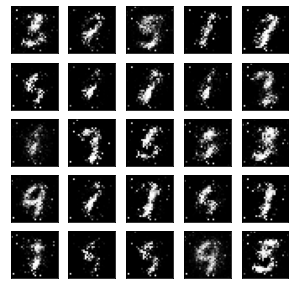

Epoch[45/200],d_loss:0.363494,g_loss:0.992228 D real: 0.887624,D fake: 0.007569
Epoch[45/200],d_loss:0.384734,g_loss:0.985336 D real: 0.850259,D fake: 0.014216
Epoch[45/200],d_loss:0.420570,g_loss:0.981537 D real: 0.920974,D fake: 0.017730
Epoch[45/200],d_loss:0.383707,g_loss:0.978401 D real: 0.857908,D fake: 0.020523


 23%|██▎       | 46/200 [26:18<1:28:20, 34.42s/it]

Epoch[46/200],d_loss:0.356170,g_loss:0.992338 D real: 0.873345,D fake: 0.007530
Epoch[46/200],d_loss:0.527174,g_loss:0.994942 D real: 0.742328,D fake: 0.004905
Epoch[46/200],d_loss:0.375447,g_loss:0.990816 D real: 0.882774,D fake: 0.009003
Epoch[46/200],d_loss:0.389099,g_loss:0.966438 D real: 0.889415,D fake: 0.031373


 24%|██▎       | 47/200 [26:52<1:27:14, 34.21s/it]

Epoch[47/200],d_loss:0.374542,g_loss:0.979067 D real: 0.884074,D fake: 0.020252
Epoch[47/200],d_loss:0.375195,g_loss:0.995416 D real: 0.852926,D fake: 0.004491
Epoch[47/200],d_loss:0.481498,g_loss:0.992856 D real: 0.826045,D fake: 0.007030
Epoch[47/200],d_loss:0.377780,g_loss:0.994223 D real: 0.895173,D fake: 0.005710


 24%|██▍       | 48/200 [27:26<1:26:20, 34.08s/it]

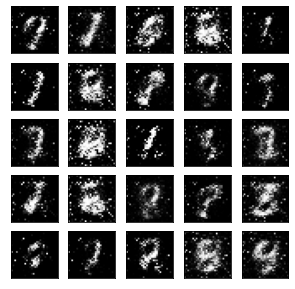

Epoch[48/200],d_loss:0.387633,g_loss:0.974983 D real: 0.875285,D fake: 0.023803
Epoch[48/200],d_loss:0.408020,g_loss:0.992354 D real: 0.902956,D fake: 0.007532
Epoch[48/200],d_loss:0.446477,g_loss:0.949766 D real: 0.900553,D fake: 0.044850
Epoch[48/200],d_loss:0.414854,g_loss:0.988566 D real: 0.824475,D fake: 0.010989


 24%|██▍       | 49/200 [28:03<1:28:27, 35.15s/it]

Epoch[49/200],d_loss:0.405850,g_loss:0.988414 D real: 0.862431,D fake: 0.011199
Epoch[49/200],d_loss:0.399966,g_loss:0.985095 D real: 0.888847,D fake: 0.014493
Epoch[49/200],d_loss:0.406491,g_loss:0.978859 D real: 0.852603,D fake: 0.019930
Epoch[49/200],d_loss:0.421284,g_loss:0.962711 D real: 0.868889,D fake: 0.034736


 25%|██▌       | 50/200 [28:36<1:25:46, 34.31s/it]

Epoch[50/200],d_loss:0.350999,g_loss:0.991868 D real: 0.886611,D fake: 0.007849
Epoch[50/200],d_loss:0.429858,g_loss:0.978478 D real: 0.877597,D fake: 0.018638
Epoch[50/200],d_loss:0.483144,g_loss:0.982744 D real: 0.829943,D fake: 0.016637
Epoch[50/200],d_loss:0.459446,g_loss:0.894378 D real: 0.883395,D fake: 0.093299


 26%|██▌       | 51/200 [29:06<1:22:25, 33.19s/it]

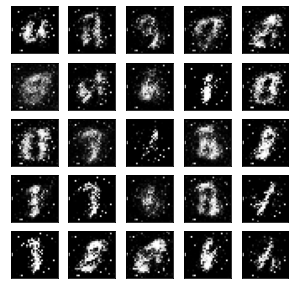

Epoch[51/200],d_loss:0.415470,g_loss:0.965429 D real: 0.887559,D fake: 0.032091
Epoch[51/200],d_loss:0.350434,g_loss:0.990067 D real: 0.893958,D fake: 0.009521
Epoch[51/200],d_loss:0.357017,g_loss:0.992366 D real: 0.891109,D fake: 0.007070
Epoch[51/200],d_loss:0.426636,g_loss:0.968506 D real: 0.863553,D fake: 0.029219


 26%|██▌       | 52/200 [29:41<1:22:47, 33.56s/it]

Epoch[52/200],d_loss:0.414913,g_loss:0.973628 D real: 0.837473,D fake: 0.025157
Epoch[52/200],d_loss:0.384257,g_loss:0.989606 D real: 0.895360,D fake: 0.010126
Epoch[52/200],d_loss:0.406080,g_loss:0.994988 D real: 0.849003,D fake: 0.004921
Epoch[52/200],d_loss:0.393365,g_loss:0.990830 D real: 0.867133,D fake: 0.008926


 26%|██▋       | 53/200 [30:14<1:22:09, 33.53s/it]

Epoch[53/200],d_loss:0.376820,g_loss:0.990724 D real: 0.880021,D fake: 0.008895
Epoch[53/200],d_loss:0.550661,g_loss:0.946518 D real: 0.832333,D fake: 0.049874
Epoch[53/200],d_loss:0.408184,g_loss:0.986692 D real: 0.884946,D fake: 0.012406
Epoch[53/200],d_loss:0.396203,g_loss:0.985770 D real: 0.857459,D fake: 0.013245


 27%|██▋       | 54/200 [30:49<1:22:21, 33.84s/it]

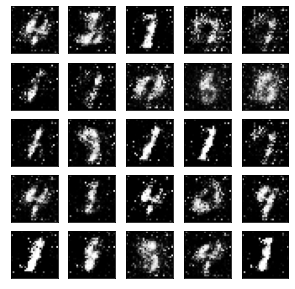

Epoch[54/200],d_loss:0.389452,g_loss:0.982681 D real: 0.892255,D fake: 0.015934
Epoch[54/200],d_loss:0.405796,g_loss:0.941449 D real: 0.898529,D fake: 0.048742
Epoch[54/200],d_loss:0.448770,g_loss:0.970423 D real: 0.902921,D fake: 0.026685
Epoch[54/200],d_loss:0.408277,g_loss:0.987238 D real: 0.841440,D fake: 0.012189


 28%|██▊       | 55/200 [31:24<1:23:03, 34.37s/it]

Epoch[55/200],d_loss:0.456813,g_loss:0.992926 D real: 0.845749,D fake: 0.006958
Epoch[55/200],d_loss:0.474981,g_loss:0.964605 D real: 0.848531,D fake: 0.030707
Epoch[55/200],d_loss:0.399246,g_loss:0.968014 D real: 0.893939,D fake: 0.029729
Epoch[55/200],d_loss:0.411039,g_loss:0.982259 D real: 0.860291,D fake: 0.017170


 28%|██▊       | 56/200 [31:57<1:21:33, 33.98s/it]

Epoch[56/200],d_loss:0.399220,g_loss:0.976600 D real: 0.857085,D fake: 0.022591
Epoch[56/200],d_loss:0.361220,g_loss:0.993657 D real: 0.873789,D fake: 0.006237
Epoch[56/200],d_loss:0.427653,g_loss:0.966151 D real: 0.848774,D fake: 0.028221
Epoch[56/200],d_loss:0.420403,g_loss:0.975633 D real: 0.894613,D fake: 0.023045


 28%|██▊       | 57/200 [32:31<1:20:38, 33.84s/it]

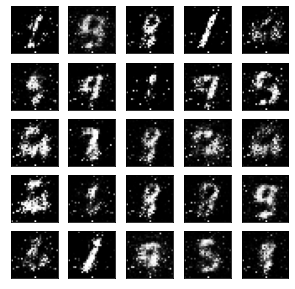

Epoch[57/200],d_loss:0.376314,g_loss:0.981038 D real: 0.889989,D fake: 0.017799
Epoch[57/200],d_loss:0.405013,g_loss:0.959383 D real: 0.870758,D fake: 0.035349
Epoch[57/200],d_loss:0.412886,g_loss:0.953151 D real: 0.883043,D fake: 0.042229
Epoch[57/200],d_loss:0.460756,g_loss:0.972561 D real: 0.870489,D fake: 0.026342


 29%|██▉       | 58/200 [33:04<1:19:56, 33.78s/it]

Epoch[58/200],d_loss:0.423291,g_loss:0.976242 D real: 0.883362,D fake: 0.022169
Epoch[58/200],d_loss:0.375419,g_loss:0.997139 D real: 0.873604,D fake: 0.002832
Epoch[58/200],d_loss:0.397124,g_loss:0.979461 D real: 0.905374,D fake: 0.019407
Epoch[58/200],d_loss:0.550488,g_loss:0.883970 D real: 0.857907,D fake: 0.094567


 30%|██▉       | 59/200 [33:38<1:19:20, 33.76s/it]

Epoch[59/200],d_loss:0.451291,g_loss:0.936221 D real: 0.866340,D fake: 0.055370
Epoch[59/200],d_loss:0.504863,g_loss:0.950582 D real: 0.827776,D fake: 0.043379
Epoch[59/200],d_loss:0.375727,g_loss:0.977518 D real: 0.897506,D fake: 0.021047
Epoch[59/200],d_loss:0.364299,g_loss:0.984410 D real: 0.893676,D fake: 0.014856


 30%|███       | 60/200 [34:09<1:16:32, 32.80s/it]

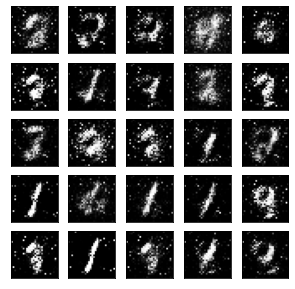

Epoch[60/200],d_loss:0.422173,g_loss:0.976510 D real: 0.873287,D fake: 0.019187
Epoch[60/200],d_loss:0.411357,g_loss:0.973438 D real: 0.844458,D fake: 0.025067
Epoch[60/200],d_loss:0.442532,g_loss:0.973627 D real: 0.891913,D fake: 0.024527
Epoch[60/200],d_loss:0.427457,g_loss:0.954503 D real: 0.912997,D fake: 0.039952


 30%|███       | 61/200 [34:42<1:16:32, 33.04s/it]

Epoch[61/200],d_loss:0.486065,g_loss:0.942161 D real: 0.885763,D fake: 0.051137
Epoch[61/200],d_loss:0.358467,g_loss:0.995273 D real: 0.878216,D fake: 0.004644
Epoch[61/200],d_loss:0.550401,g_loss:0.926418 D real: 0.761531,D fake: 0.062461
Epoch[61/200],d_loss:0.427480,g_loss:0.980453 D real: 0.856366,D fake: 0.018702


 31%|███       | 62/200 [35:15<1:15:35, 32.87s/it]

Epoch[62/200],d_loss:0.529710,g_loss:0.924565 D real: 0.821208,D fake: 0.060566
Epoch[62/200],d_loss:0.381371,g_loss:0.987944 D real: 0.871728,D fake: 0.011212
Epoch[62/200],d_loss:0.635903,g_loss:0.839904 D real: 0.781341,D fake: 0.118197
Epoch[62/200],d_loss:0.476219,g_loss:0.941691 D real: 0.884388,D fake: 0.044062


 32%|███▏      | 63/200 [35:48<1:15:05, 32.89s/it]

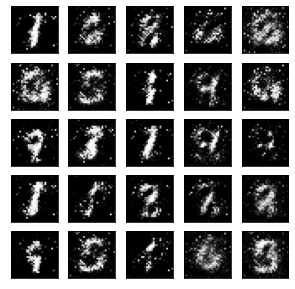

Epoch[63/200],d_loss:0.774691,g_loss:0.888800 D real: 0.856819,D fake: 0.090502
Epoch[63/200],d_loss:0.496376,g_loss:0.924919 D real: 0.817358,D fake: 0.066159
Epoch[63/200],d_loss:0.468327,g_loss:0.983115 D real: 0.833509,D fake: 0.016465
Epoch[63/200],d_loss:0.448942,g_loss:0.980274 D real: 0.876330,D fake: 0.019081


 32%|███▏      | 64/200 [36:20<1:13:49, 32.57s/it]

Epoch[64/200],d_loss:0.459318,g_loss:0.993339 D real: 0.806286,D fake: 0.006533
Epoch[64/200],d_loss:0.640300,g_loss:0.902128 D real: 0.709801,D fake: 0.087579
Epoch[64/200],d_loss:0.365076,g_loss:0.982004 D real: 0.888463,D fake: 0.016928
Epoch[64/200],d_loss:0.428754,g_loss:0.991205 D real: 0.836212,D fake: 0.008276


 32%|███▎      | 65/200 [36:52<1:13:09, 32.52s/it]

Epoch[65/200],d_loss:0.542282,g_loss:0.968772 D real: 0.799752,D fake: 0.027525
Epoch[65/200],d_loss:0.391178,g_loss:0.993918 D real: 0.861203,D fake: 0.005952
Epoch[65/200],d_loss:0.466039,g_loss:0.940891 D real: 0.834542,D fake: 0.053171
Epoch[65/200],d_loss:0.529584,g_loss:0.929505 D real: 0.891554,D fake: 0.049001


 33%|███▎      | 66/200 [37:28<1:15:05, 33.62s/it]

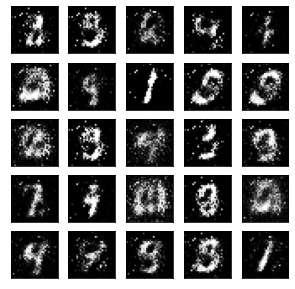

Epoch[66/200],d_loss:0.585271,g_loss:0.883871 D real: 0.817838,D fake: 0.091932
Epoch[66/200],d_loss:0.664235,g_loss:0.673506 D real: 0.716508,D fake: 0.235461
Epoch[66/200],d_loss:0.399092,g_loss:0.959413 D real: 0.905999,D fake: 0.037433
Epoch[66/200],d_loss:0.374339,g_loss:0.984739 D real: 0.890597,D fake: 0.014236


 34%|███▎      | 67/200 [38:03<1:15:15, 33.95s/it]

Epoch[67/200],d_loss:0.465192,g_loss:0.939427 D real: 0.851623,D fake: 0.054038
Epoch[67/200],d_loss:0.444121,g_loss:0.904200 D real: 0.896104,D fake: 0.074532
Epoch[67/200],d_loss:0.556516,g_loss:0.974711 D real: 0.736974,D fake: 0.024359
Epoch[67/200],d_loss:0.400127,g_loss:0.983908 D real: 0.900088,D fake: 0.014795


 34%|███▍      | 68/200 [38:37<1:15:07, 34.15s/it]

Epoch[68/200],d_loss:0.683044,g_loss:0.924741 D real: 0.679146,D fake: 0.061320
Epoch[68/200],d_loss:0.420897,g_loss:0.955338 D real: 0.867499,D fake: 0.041433
Epoch[68/200],d_loss:0.642873,g_loss:0.943953 D real: 0.802483,D fake: 0.050321
Epoch[68/200],d_loss:0.455010,g_loss:0.970000 D real: 0.836846,D fake: 0.027585


 34%|███▍      | 69/200 [39:11<1:14:10, 33.97s/it]

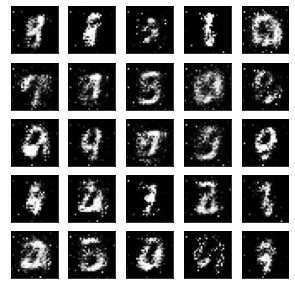

Epoch[69/200],d_loss:0.413817,g_loss:0.980378 D real: 0.837141,D fake: 0.017798
Epoch[69/200],d_loss:0.460329,g_loss:0.985423 D real: 0.845657,D fake: 0.013997
Epoch[69/200],d_loss:0.481859,g_loss:0.949538 D real: 0.816934,D fake: 0.042531
Epoch[69/200],d_loss:0.499190,g_loss:0.975384 D real: 0.858366,D fake: 0.023074


 35%|███▌      | 70/200 [39:45<1:13:51, 34.09s/it]

Epoch[70/200],d_loss:0.430961,g_loss:0.965785 D real: 0.869472,D fake: 0.027705
Epoch[70/200],d_loss:0.653159,g_loss:0.959437 D real: 0.721283,D fake: 0.036954
Epoch[70/200],d_loss:0.471892,g_loss:0.894776 D real: 0.854137,D fake: 0.091164
Epoch[70/200],d_loss:0.471130,g_loss:0.975410 D real: 0.857845,D fake: 0.022955


 36%|███▌      | 71/200 [40:18<1:12:05, 33.53s/it]

Epoch[71/200],d_loss:0.596704,g_loss:0.935137 D real: 0.754586,D fake: 0.052792
Epoch[71/200],d_loss:0.752542,g_loss:0.761145 D real: 0.722444,D fake: 0.173401
Epoch[71/200],d_loss:0.513189,g_loss:0.966309 D real: 0.820587,D fake: 0.031659
Epoch[71/200],d_loss:0.469536,g_loss:0.955087 D real: 0.860476,D fake: 0.038269


 36%|███▌      | 72/200 [40:50<1:10:33, 33.07s/it]

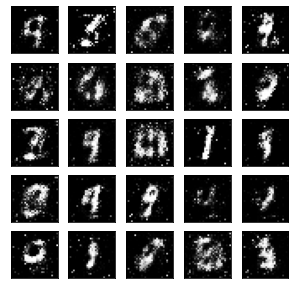

Epoch[72/200],d_loss:0.472600,g_loss:0.940651 D real: 0.883411,D fake: 0.052612
Epoch[72/200],d_loss:0.786728,g_loss:0.928012 D real: 0.672966,D fake: 0.064617
Epoch[72/200],d_loss:0.465405,g_loss:0.962596 D real: 0.847157,D fake: 0.034866
Epoch[72/200],d_loss:0.393924,g_loss:0.956351 D real: 0.902358,D fake: 0.032474


 36%|███▋      | 73/200 [41:27<1:12:57, 34.47s/it]

Epoch[73/200],d_loss:0.505615,g_loss:0.927388 D real: 0.846360,D fake: 0.059910
Epoch[73/200],d_loss:0.566643,g_loss:0.875675 D real: 0.825591,D fake: 0.099974
Epoch[73/200],d_loss:0.594891,g_loss:0.819884 D real: 0.777711,D fake: 0.136622
Epoch[73/200],d_loss:0.543306,g_loss:0.954108 D real: 0.790136,D fake: 0.039656


 37%|███▋      | 74/200 [42:03<1:12:51, 34.69s/it]

Epoch[74/200],d_loss:0.516218,g_loss:0.951233 D real: 0.762730,D fake: 0.043233
Epoch[74/200],d_loss:0.435782,g_loss:0.981433 D real: 0.853505,D fake: 0.017556
Epoch[74/200],d_loss:0.580239,g_loss:0.900329 D real: 0.797032,D fake: 0.081424
Epoch[74/200],d_loss:0.482916,g_loss:0.895087 D real: 0.861983,D fake: 0.086267


 38%|███▊      | 75/200 [42:34<1:10:32, 33.86s/it]

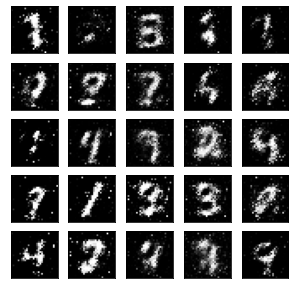

Epoch[75/200],d_loss:0.596132,g_loss:0.895532 D real: 0.745938,D fake: 0.084037
Epoch[75/200],d_loss:0.801561,g_loss:0.903981 D real: 0.749109,D fake: 0.076684
Epoch[75/200],d_loss:0.494547,g_loss:0.956960 D real: 0.835542,D fake: 0.036968
Epoch[75/200],d_loss:0.863146,g_loss:0.872557 D real: 0.791485,D fake: 0.107598


 38%|███▊      | 76/200 [43:11<1:11:30, 34.60s/it]

Epoch[76/200],d_loss:0.676502,g_loss:0.882727 D real: 0.733339,D fake: 0.096625
Epoch[76/200],d_loss:0.401945,g_loss:0.988027 D real: 0.911327,D fake: 0.011327
Epoch[76/200],d_loss:0.465488,g_loss:0.974578 D real: 0.814607,D fake: 0.023330
Epoch[76/200],d_loss:0.547857,g_loss:0.931421 D real: 0.815672,D fake: 0.059445


 38%|███▊      | 77/200 [43:43<1:09:18, 33.81s/it]

Epoch[77/200],d_loss:0.609162,g_loss:0.912079 D real: 0.819503,D fake: 0.075165
Epoch[77/200],d_loss:0.468299,g_loss:0.965672 D real: 0.861566,D fake: 0.031041
Epoch[77/200],d_loss:0.588498,g_loss:0.867924 D real: 0.889237,D fake: 0.100518
Epoch[77/200],d_loss:0.555689,g_loss:0.898497 D real: 0.814218,D fake: 0.090039


 39%|███▉      | 78/200 [44:15<1:07:56, 33.42s/it]

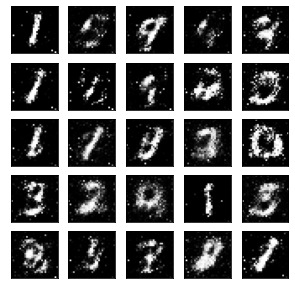

Epoch[78/200],d_loss:0.445602,g_loss:0.952365 D real: 0.888742,D fake: 0.043410
Epoch[78/200],d_loss:0.564313,g_loss:0.983793 D real: 0.771592,D fake: 0.015456
Epoch[78/200],d_loss:0.438607,g_loss:0.966236 D real: 0.874327,D fake: 0.030687
Epoch[78/200],d_loss:0.686466,g_loss:0.851964 D real: 0.720032,D fake: 0.118898


 40%|███▉      | 79/200 [44:50<1:08:01, 33.73s/it]

Epoch[79/200],d_loss:0.456687,g_loss:0.961240 D real: 0.827117,D fake: 0.033641
Epoch[79/200],d_loss:0.575699,g_loss:0.854069 D real: 0.899902,D fake: 0.108966
Epoch[79/200],d_loss:0.786147,g_loss:0.872983 D real: 0.698583,D fake: 0.103302
Epoch[79/200],d_loss:0.430672,g_loss:0.980174 D real: 0.863715,D fake: 0.018158


 40%|████      | 80/200 [45:20<1:05:09, 32.58s/it]

Epoch[80/200],d_loss:0.473505,g_loss:0.958968 D real: 0.831608,D fake: 0.038357
Epoch[80/200],d_loss:0.642552,g_loss:0.947066 D real: 0.757018,D fake: 0.048471
Epoch[80/200],d_loss:0.423040,g_loss:0.971314 D real: 0.878465,D fake: 0.026254
Epoch[80/200],d_loss:0.730856,g_loss:0.873179 D real: 0.797686,D fake: 0.106927


 40%|████      | 81/200 [45:50<1:03:34, 32.06s/it]

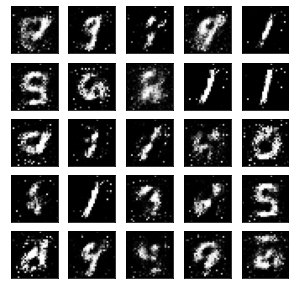

Epoch[81/200],d_loss:0.609552,g_loss:0.952463 D real: 0.768019,D fake: 0.042502
Epoch[81/200],d_loss:0.647071,g_loss:0.906953 D real: 0.817106,D fake: 0.077162
Epoch[81/200],d_loss:0.608599,g_loss:0.865356 D real: 0.773175,D fake: 0.112947
Epoch[81/200],d_loss:0.484534,g_loss:0.959627 D real: 0.834685,D fake: 0.036110


 41%|████      | 82/200 [46:25<1:04:23, 32.74s/it]

Epoch[82/200],d_loss:0.440427,g_loss:0.941357 D real: 0.858783,D fake: 0.049865
Epoch[82/200],d_loss:0.480065,g_loss:0.953661 D real: 0.822765,D fake: 0.041574
Epoch[82/200],d_loss:0.589198,g_loss:0.925902 D real: 0.756378,D fake: 0.060598
Epoch[82/200],d_loss:0.582172,g_loss:0.907048 D real: 0.850945,D fake: 0.080705


 42%|████▏     | 83/200 [46:55<1:02:32, 32.07s/it]

Epoch[83/200],d_loss:0.678913,g_loss:0.815162 D real: 0.789038,D fake: 0.141171
Epoch[83/200],d_loss:0.737082,g_loss:0.916679 D real: 0.709229,D fake: 0.073696
Epoch[83/200],d_loss:0.602017,g_loss:0.870440 D real: 0.814050,D fake: 0.107651
Epoch[83/200],d_loss:0.455997,g_loss:0.957293 D real: 0.860662,D fake: 0.037748


 42%|████▏     | 84/200 [47:25<1:00:26, 31.26s/it]

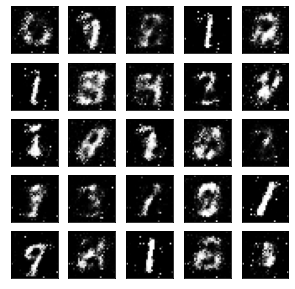

Epoch[84/200],d_loss:0.549887,g_loss:0.896282 D real: 0.816134,D fake: 0.088705
Epoch[84/200],d_loss:0.752131,g_loss:0.897642 D real: 0.753655,D fake: 0.085266
Epoch[84/200],d_loss:0.481434,g_loss:0.955790 D real: 0.819845,D fake: 0.038901
Epoch[84/200],d_loss:0.702252,g_loss:0.873131 D real: 0.706230,D fake: 0.106989


 42%|████▎     | 85/200 [48:01<1:02:38, 32.68s/it]

Epoch[85/200],d_loss:0.553504,g_loss:0.878766 D real: 0.833638,D fake: 0.093928
Epoch[85/200],d_loss:0.701901,g_loss:0.820955 D real: 0.732929,D fake: 0.151807
Epoch[85/200],d_loss:0.677404,g_loss:0.866326 D real: 0.714481,D fake: 0.112675
Epoch[85/200],d_loss:0.462442,g_loss:0.941144 D real: 0.882118,D fake: 0.052718


 43%|████▎     | 86/200 [48:35<1:02:59, 33.15s/it]

Epoch[86/200],d_loss:0.538521,g_loss:0.894493 D real: 0.856275,D fake: 0.089577
Epoch[86/200],d_loss:0.594643,g_loss:0.875939 D real: 0.854435,D fake: 0.106203
Epoch[86/200],d_loss:0.607836,g_loss:0.900255 D real: 0.799275,D fake: 0.082422
Epoch[86/200],d_loss:0.554340,g_loss:0.908407 D real: 0.832747,D fake: 0.069311


 44%|████▎     | 87/200 [49:08<1:02:11, 33.02s/it]

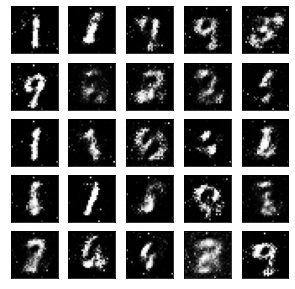

Epoch[87/200],d_loss:0.610817,g_loss:0.746105 D real: 0.842120,D fake: 0.191804
Epoch[87/200],d_loss:0.593047,g_loss:0.896933 D real: 0.837821,D fake: 0.079103
Epoch[87/200],d_loss:0.914427,g_loss:0.590553 D real: 0.705259,D fake: 0.285202
Epoch[87/200],d_loss:0.497927,g_loss:0.933618 D real: 0.851988,D fake: 0.059477


 44%|████▍     | 88/200 [49:42<1:02:21, 33.41s/it]

Epoch[88/200],d_loss:0.399796,g_loss:0.982617 D real: 0.891123,D fake: 0.016448
Epoch[88/200],d_loss:0.496676,g_loss:0.949595 D real: 0.841447,D fake: 0.041950
Epoch[88/200],d_loss:0.680598,g_loss:0.915331 D real: 0.767730,D fake: 0.075775
Epoch[88/200],d_loss:0.638319,g_loss:0.899419 D real: 0.740713,D fake: 0.086165


 44%|████▍     | 89/200 [50:14<1:00:57, 32.95s/it]

Epoch[89/200],d_loss:0.500860,g_loss:0.979974 D real: 0.795206,D fake: 0.018953
Epoch[89/200],d_loss:0.676141,g_loss:0.813377 D real: 0.765720,D fake: 0.148038
Epoch[89/200],d_loss:1.029736,g_loss:0.879203 D real: 0.563800,D fake: 0.101312
Epoch[89/200],d_loss:0.615883,g_loss:0.889779 D real: 0.736662,D fake: 0.097029


 45%|████▌     | 90/200 [50:46<59:50, 32.64s/it]  

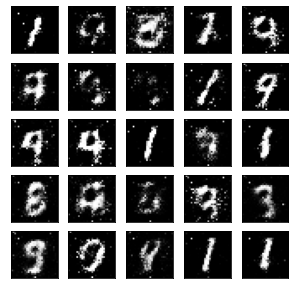

Epoch[90/200],d_loss:0.661989,g_loss:0.849534 D real: 0.710011,D fake: 0.123847
Epoch[90/200],d_loss:0.482959,g_loss:0.971191 D real: 0.866707,D fake: 0.025390
Epoch[90/200],d_loss:0.670988,g_loss:0.859587 D real: 0.740548,D fake: 0.114803
Epoch[90/200],d_loss:0.527633,g_loss:0.919827 D real: 0.854426,D fake: 0.070018


 46%|████▌     | 91/200 [51:22<1:01:13, 33.70s/it]

Epoch[91/200],d_loss:0.546696,g_loss:0.929025 D real: 0.832735,D fake: 0.061334
Epoch[91/200],d_loss:0.618212,g_loss:0.706083 D real: 0.787711,D fake: 0.218112
Epoch[91/200],d_loss:0.545228,g_loss:0.922101 D real: 0.814886,D fake: 0.064688
Epoch[91/200],d_loss:0.691698,g_loss:0.762520 D real: 0.768382,D fake: 0.177468


 46%|████▌     | 92/200 [51:57<1:01:21, 34.08s/it]

Epoch[92/200],d_loss:0.749395,g_loss:0.825992 D real: 0.770702,D fake: 0.142732
Epoch[92/200],d_loss:0.774670,g_loss:0.821011 D real: 0.759933,D fake: 0.143459
Epoch[92/200],d_loss:0.598575,g_loss:0.929284 D real: 0.808086,D fake: 0.058374
Epoch[92/200],d_loss:0.730538,g_loss:0.782970 D real: 0.747542,D fake: 0.165429


 46%|████▋     | 93/200 [52:33<1:01:36, 34.55s/it]

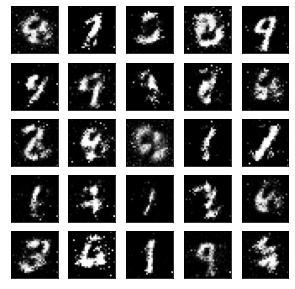

Epoch[93/200],d_loss:0.827314,g_loss:0.743650 D real: 0.668289,D fake: 0.202195
Epoch[93/200],d_loss:0.717418,g_loss:0.889169 D real: 0.756891,D fake: 0.092692
Epoch[93/200],d_loss:0.643570,g_loss:0.875742 D real: 0.801054,D fake: 0.106391
Epoch[93/200],d_loss:0.613857,g_loss:0.888676 D real: 0.812147,D fake: 0.093785


 47%|████▋     | 94/200 [53:11<1:02:57, 35.63s/it]

Epoch[94/200],d_loss:0.524687,g_loss:0.918870 D real: 0.828228,D fake: 0.069498
Epoch[94/200],d_loss:0.736429,g_loss:0.837565 D real: 0.766640,D fake: 0.137406
Epoch[94/200],d_loss:0.614802,g_loss:0.878298 D real: 0.806555,D fake: 0.102689
Epoch[94/200],d_loss:0.573065,g_loss:0.874796 D real: 0.853701,D fake: 0.108894


 48%|████▊     | 95/200 [53:46<1:02:19, 35.61s/it]

Epoch[95/200],d_loss:0.735412,g_loss:0.835158 D real: 0.801842,D fake: 0.133664
Epoch[95/200],d_loss:0.690649,g_loss:0.902508 D real: 0.764753,D fake: 0.083845
Epoch[95/200],d_loss:0.700092,g_loss:0.876735 D real: 0.784987,D fake: 0.106327
Epoch[95/200],d_loss:0.660143,g_loss:0.857398 D real: 0.775662,D fake: 0.117054


 48%|████▊     | 96/200 [54:17<59:12, 34.16s/it]  

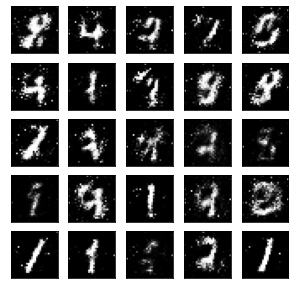

Epoch[96/200],d_loss:0.731242,g_loss:0.869126 D real: 0.839696,D fake: 0.104953
Epoch[96/200],d_loss:0.563264,g_loss:0.873420 D real: 0.817922,D fake: 0.100288
Epoch[96/200],d_loss:0.689797,g_loss:0.848049 D real: 0.770690,D fake: 0.122946
Epoch[96/200],d_loss:0.700466,g_loss:0.827748 D real: 0.743873,D fake: 0.142717


 48%|████▊     | 97/200 [54:54<59:50, 34.86s/it]

Epoch[97/200],d_loss:0.721463,g_loss:0.828471 D real: 0.674607,D fake: 0.133383
Epoch[97/200],d_loss:0.541965,g_loss:0.915664 D real: 0.787042,D fake: 0.073421
Epoch[97/200],d_loss:0.619348,g_loss:0.897155 D real: 0.883504,D fake: 0.089699
Epoch[97/200],d_loss:0.549070,g_loss:0.895671 D real: 0.810485,D fake: 0.091008


 49%|████▉     | 98/200 [55:27<58:19, 34.31s/it]

Epoch[98/200],d_loss:0.764667,g_loss:0.712533 D real: 0.763140,D fake: 0.218588
Epoch[98/200],d_loss:0.632445,g_loss:0.849931 D real: 0.809357,D fake: 0.118982
Epoch[98/200],d_loss:0.569438,g_loss:0.858580 D real: 0.816511,D fake: 0.115889
Epoch[98/200],d_loss:0.685650,g_loss:0.880742 D real: 0.811221,D fake: 0.101080


 50%|████▉     | 99/200 [56:02<58:15, 34.61s/it]

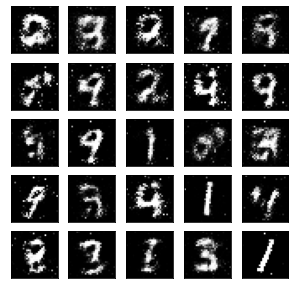

Epoch[99/200],d_loss:1.075456,g_loss:0.783136 D real: 0.620612,D fake: 0.175168
Epoch[99/200],d_loss:0.723368,g_loss:0.887780 D real: 0.774320,D fake: 0.091634
Epoch[99/200],d_loss:0.726088,g_loss:0.754243 D real: 0.700516,D fake: 0.188228
Epoch[99/200],d_loss:0.578402,g_loss:0.919200 D real: 0.792218,D fake: 0.071958


 50%|█████     | 100/200 [56:39<58:55, 35.36s/it]

Epoch[100/200],d_loss:0.658910,g_loss:0.876461 D real: 0.750107,D fake: 0.104045
Epoch[100/200],d_loss:0.681165,g_loss:0.814938 D real: 0.789769,D fake: 0.149637
Epoch[100/200],d_loss:0.658055,g_loss:0.952980 D real: 0.696953,D fake: 0.041622
Epoch[100/200],d_loss:0.837484,g_loss:0.814684 D real: 0.686403,D fake: 0.150735


 50%|█████     | 101/200 [57:13<57:51, 35.06s/it]

Epoch[101/200],d_loss:0.547038,g_loss:0.908983 D real: 0.875261,D fake: 0.078428
Epoch[101/200],d_loss:0.737238,g_loss:0.828465 D real: 0.735270,D fake: 0.143573
Epoch[101/200],d_loss:0.664745,g_loss:0.856885 D real: 0.793686,D fake: 0.120441
Epoch[101/200],d_loss:0.519157,g_loss:0.961329 D real: 0.848777,D fake: 0.035822


 51%|█████     | 102/200 [57:48<57:13, 35.04s/it]

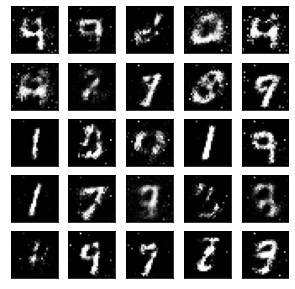

Epoch[102/200],d_loss:0.532608,g_loss:0.895643 D real: 0.863719,D fake: 0.087077
Epoch[102/200],d_loss:0.524967,g_loss:0.902427 D real: 0.817025,D fake: 0.081758
Epoch[102/200],d_loss:0.724445,g_loss:0.816237 D real: 0.705793,D fake: 0.144144
Epoch[102/200],d_loss:0.770112,g_loss:0.796373 D real: 0.815649,D fake: 0.154873


 52%|█████▏    | 103/200 [58:24<57:11, 35.37s/it]

Epoch[103/200],d_loss:0.675339,g_loss:0.807278 D real: 0.753529,D fake: 0.153237
Epoch[103/200],d_loss:0.741833,g_loss:0.871950 D real: 0.728334,D fake: 0.103376
Epoch[103/200],d_loss:0.627185,g_loss:0.932122 D real: 0.853890,D fake: 0.060715
Epoch[103/200],d_loss:0.860040,g_loss:0.699169 D real: 0.699121,D fake: 0.216939


 52%|█████▏    | 104/200 [58:59<56:15, 35.16s/it]

Epoch[104/200],d_loss:0.621126,g_loss:0.913538 D real: 0.811154,D fake: 0.075282
Epoch[104/200],d_loss:0.692511,g_loss:0.812497 D real: 0.802030,D fake: 0.146473
Epoch[104/200],d_loss:0.594503,g_loss:0.855431 D real: 0.773555,D fake: 0.123738
Epoch[104/200],d_loss:0.843612,g_loss:0.726176 D real: 0.713685,D fake: 0.217419


 52%|█████▎    | 105/200 [59:31<54:11, 34.23s/it]

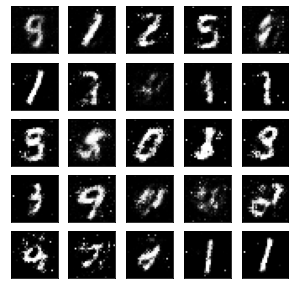

Epoch[105/200],d_loss:0.919895,g_loss:0.732572 D real: 0.643783,D fake: 0.213452
Epoch[105/200],d_loss:0.674904,g_loss:0.798417 D real: 0.783889,D fake: 0.152396
Epoch[105/200],d_loss:0.748531,g_loss:0.816006 D real: 0.759341,D fake: 0.153518
Epoch[105/200],d_loss:0.635701,g_loss:0.914031 D real: 0.821761,D fake: 0.071326


 53%|█████▎    | 106/200 [1:00:08<54:42, 34.92s/it]

Epoch[106/200],d_loss:0.984425,g_loss:0.768546 D real: 0.683300,D fake: 0.181288
Epoch[106/200],d_loss:0.619808,g_loss:0.866802 D real: 0.781114,D fake: 0.109909
Epoch[106/200],d_loss:0.909382,g_loss:0.754587 D real: 0.724537,D fake: 0.199457
Epoch[106/200],d_loss:0.667010,g_loss:0.848321 D real: 0.785818,D fake: 0.128268


 54%|█████▎    | 107/200 [1:00:42<53:51, 34.75s/it]

Epoch[107/200],d_loss:0.562342,g_loss:0.869494 D real: 0.783899,D fake: 0.105232
Epoch[107/200],d_loss:0.713147,g_loss:0.839404 D real: 0.740034,D fake: 0.136467
Epoch[107/200],d_loss:0.613267,g_loss:0.906491 D real: 0.804849,D fake: 0.078879
Epoch[107/200],d_loss:0.816986,g_loss:0.844017 D real: 0.650830,D fake: 0.128639


 54%|█████▍    | 108/200 [1:01:18<53:48, 35.09s/it]

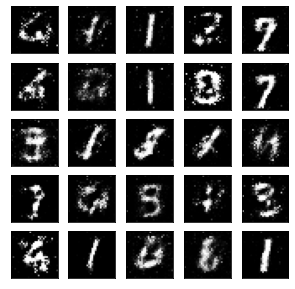

Epoch[108/200],d_loss:0.587473,g_loss:0.875501 D real: 0.783927,D fake: 0.104690
Epoch[108/200],d_loss:0.663136,g_loss:0.779698 D real: 0.714130,D fake: 0.176146
Epoch[108/200],d_loss:0.548103,g_loss:0.960846 D real: 0.771366,D fake: 0.035653
Epoch[108/200],d_loss:0.765038,g_loss:0.827776 D real: 0.729961,D fake: 0.141417


 55%|█████▍    | 109/200 [1:01:55<54:11, 35.73s/it]

Epoch[109/200],d_loss:0.710471,g_loss:0.803646 D real: 0.727233,D fake: 0.148861
Epoch[109/200],d_loss:0.548641,g_loss:0.804945 D real: 0.858225,D fake: 0.158452
Epoch[109/200],d_loss:0.716163,g_loss:0.861308 D real: 0.761354,D fake: 0.117759
Epoch[109/200],d_loss:0.792914,g_loss:0.688697 D real: 0.741042,D fake: 0.234104


 55%|█████▌    | 110/200 [1:02:29<52:33, 35.03s/it]

Epoch[110/200],d_loss:0.798269,g_loss:0.740123 D real: 0.664424,D fake: 0.212581
Epoch[110/200],d_loss:0.842524,g_loss:0.611576 D real: 0.648786,D fake: 0.279691
Epoch[110/200],d_loss:0.708082,g_loss:0.823905 D real: 0.826593,D fake: 0.144046
Epoch[110/200],d_loss:0.794875,g_loss:0.809541 D real: 0.703835,D fake: 0.153457


 56%|█████▌    | 111/200 [1:03:03<51:28, 34.71s/it]

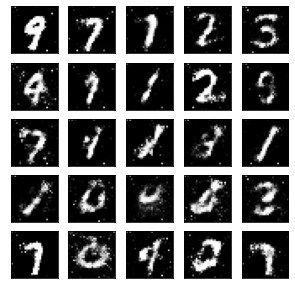

Epoch[111/200],d_loss:0.593301,g_loss:0.875747 D real: 0.754238,D fake: 0.101884
Epoch[111/200],d_loss:0.661393,g_loss:0.912798 D real: 0.850589,D fake: 0.076701
Epoch[111/200],d_loss:0.750735,g_loss:0.856559 D real: 0.699668,D fake: 0.118417
Epoch[111/200],d_loss:0.632458,g_loss:0.833744 D real: 0.750930,D fake: 0.136867


 56%|█████▌    | 112/200 [1:03:41<52:42, 35.94s/it]

Epoch[112/200],d_loss:0.615801,g_loss:0.864492 D real: 0.780809,D fake: 0.112323
Epoch[112/200],d_loss:0.606142,g_loss:0.946896 D real: 0.748304,D fake: 0.048333
Epoch[112/200],d_loss:0.641083,g_loss:0.886030 D real: 0.746582,D fake: 0.095435
Epoch[112/200],d_loss:0.723271,g_loss:0.898473 D real: 0.693131,D fake: 0.088573


 56%|█████▋    | 113/200 [1:04:16<51:38, 35.62s/it]

Epoch[113/200],d_loss:0.579746,g_loss:0.948241 D real: 0.832433,D fake: 0.046439
Epoch[113/200],d_loss:0.675755,g_loss:0.790404 D real: 0.767533,D fake: 0.167941
Epoch[113/200],d_loss:0.721782,g_loss:0.791635 D real: 0.746620,D fake: 0.167631
Epoch[113/200],d_loss:0.734315,g_loss:0.844577 D real: 0.768613,D fake: 0.130518


 57%|█████▋    | 114/200 [1:04:52<51:03, 35.62s/it]

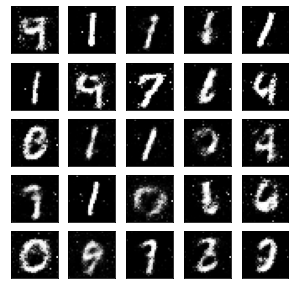

Epoch[114/200],d_loss:0.678896,g_loss:0.890859 D real: 0.708724,D fake: 0.092703
Epoch[114/200],d_loss:0.691623,g_loss:0.857180 D real: 0.779348,D fake: 0.120299
Epoch[114/200],d_loss:0.721739,g_loss:0.767147 D real: 0.754952,D fake: 0.184056
Epoch[114/200],d_loss:0.838114,g_loss:0.754673 D real: 0.720488,D fake: 0.198724


 57%|█████▊    | 115/200 [1:05:28<50:51, 35.90s/it]

Epoch[115/200],d_loss:0.936495,g_loss:0.681582 D real: 0.720518,D fake: 0.244577
Epoch[115/200],d_loss:0.867532,g_loss:0.736210 D real: 0.599675,D fake: 0.204395
Epoch[115/200],d_loss:0.742942,g_loss:0.805077 D real: 0.680504,D fake: 0.154303
Epoch[115/200],d_loss:0.615102,g_loss:0.800242 D real: 0.824028,D fake: 0.156373


 58%|█████▊    | 116/200 [1:06:08<51:38, 36.89s/it]

Epoch[116/200],d_loss:0.980345,g_loss:0.723304 D real: 0.632295,D fake: 0.222491
Epoch[116/200],d_loss:0.844553,g_loss:0.717967 D real: 0.651735,D fake: 0.215813
Epoch[116/200],d_loss:1.009181,g_loss:0.628064 D real: 0.683070,D fake: 0.261999
Epoch[116/200],d_loss:0.722959,g_loss:0.801385 D real: 0.696169,D fake: 0.159694


 58%|█████▊    | 117/200 [1:06:46<51:43, 37.39s/it]

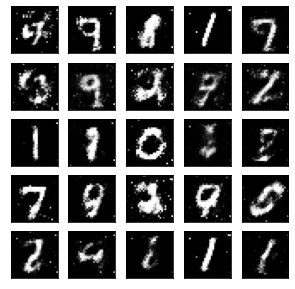

Epoch[117/200],d_loss:0.736033,g_loss:0.834372 D real: 0.680633,D fake: 0.136958
Epoch[117/200],d_loss:0.609216,g_loss:0.915268 D real: 0.786140,D fake: 0.072598
Epoch[117/200],d_loss:0.779289,g_loss:0.814584 D real: 0.737828,D fake: 0.151423
Epoch[117/200],d_loss:0.793460,g_loss:0.783315 D real: 0.715074,D fake: 0.161722


 59%|█████▉    | 118/200 [1:07:24<51:11, 37.45s/it]

Epoch[118/200],d_loss:0.935262,g_loss:0.835011 D real: 0.604553,D fake: 0.133830
Epoch[118/200],d_loss:0.713730,g_loss:0.827673 D real: 0.767375,D fake: 0.143126
Epoch[118/200],d_loss:0.853932,g_loss:0.815522 D real: 0.677137,D fake: 0.147475
Epoch[118/200],d_loss:0.742883,g_loss:0.776161 D real: 0.704535,D fake: 0.182228


 60%|█████▉    | 119/200 [1:07:56<48:30, 35.93s/it]

Epoch[119/200],d_loss:0.567841,g_loss:0.900171 D real: 0.764038,D fake: 0.081083
Epoch[119/200],d_loss:0.810784,g_loss:0.817201 D real: 0.677482,D fake: 0.139716
Epoch[119/200],d_loss:0.726400,g_loss:0.785292 D real: 0.737407,D fake: 0.172830
Epoch[119/200],d_loss:0.882784,g_loss:0.694005 D real: 0.659290,D fake: 0.217733


 60%|██████    | 120/200 [1:08:33<48:10, 36.13s/it]

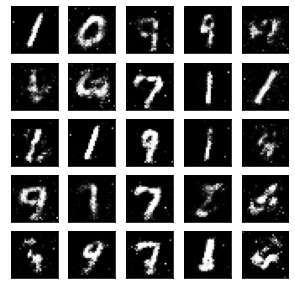

Epoch[120/200],d_loss:0.772542,g_loss:0.761777 D real: 0.691437,D fake: 0.181200
Epoch[120/200],d_loss:0.801670,g_loss:0.803465 D real: 0.666627,D fake: 0.156375
Epoch[120/200],d_loss:1.016608,g_loss:0.756069 D real: 0.621643,D fake: 0.200486
Epoch[120/200],d_loss:0.734752,g_loss:0.740917 D real: 0.758094,D fake: 0.194733


 60%|██████    | 121/200 [1:09:10<48:06, 36.54s/it]

Epoch[121/200],d_loss:0.506370,g_loss:0.927584 D real: 0.818037,D fake: 0.059619
Epoch[121/200],d_loss:0.691795,g_loss:0.769069 D real: 0.764657,D fake: 0.184922
Epoch[121/200],d_loss:0.675422,g_loss:0.843274 D real: 0.714370,D fake: 0.129439
Epoch[121/200],d_loss:0.831391,g_loss:0.887337 D real: 0.722434,D fake: 0.091949


 61%|██████    | 122/200 [1:09:45<46:42, 35.93s/it]

Epoch[122/200],d_loss:0.675801,g_loss:0.915923 D real: 0.713849,D fake: 0.071882
Epoch[122/200],d_loss:0.657509,g_loss:0.832862 D real: 0.865204,D fake: 0.136351
Epoch[122/200],d_loss:0.876728,g_loss:0.756750 D real: 0.656554,D fake: 0.190107
Epoch[122/200],d_loss:1.046665,g_loss:0.624756 D real: 0.752025,D fake: 0.279704


 62%|██████▏   | 123/200 [1:10:17<44:46, 34.90s/it]

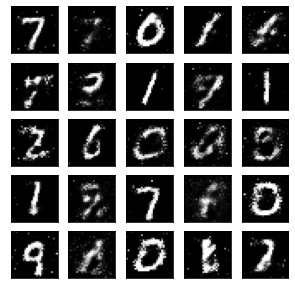

Epoch[123/200],d_loss:0.658772,g_loss:0.830683 D real: 0.812124,D fake: 0.131117
Epoch[123/200],d_loss:0.742248,g_loss:0.842196 D real: 0.784561,D fake: 0.127897
Epoch[123/200],d_loss:0.700731,g_loss:0.862974 D real: 0.712026,D fake: 0.115955
Epoch[123/200],d_loss:0.654581,g_loss:0.838236 D real: 0.773751,D fake: 0.137017


 62%|██████▏   | 124/200 [1:10:54<44:47, 35.36s/it]

Epoch[124/200],d_loss:0.781238,g_loss:0.760124 D real: 0.708876,D fake: 0.188738
Epoch[124/200],d_loss:0.765833,g_loss:0.848342 D real: 0.729420,D fake: 0.123178
Epoch[124/200],d_loss:0.737242,g_loss:0.753578 D real: 0.727473,D fake: 0.192995
Epoch[124/200],d_loss:0.675378,g_loss:0.844124 D real: 0.844919,D fake: 0.129845


 62%|██████▎   | 125/200 [1:11:28<43:42, 34.96s/it]

Epoch[125/200],d_loss:0.802609,g_loss:0.855863 D real: 0.755774,D fake: 0.118416
Epoch[125/200],d_loss:0.789723,g_loss:0.725791 D real: 0.751494,D fake: 0.208498
Epoch[125/200],d_loss:0.719967,g_loss:0.807464 D real: 0.813877,D fake: 0.158366
Epoch[125/200],d_loss:0.585391,g_loss:0.872103 D real: 0.768664,D fake: 0.109791


 63%|██████▎   | 126/200 [1:12:01<42:40, 34.60s/it]

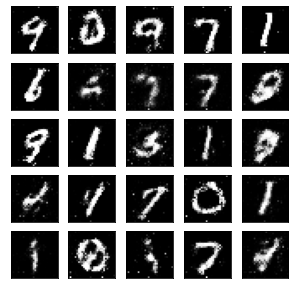

Epoch[126/200],d_loss:0.777841,g_loss:0.751346 D real: 0.715210,D fake: 0.187080
Epoch[126/200],d_loss:0.638435,g_loss:0.909397 D real: 0.757993,D fake: 0.079938
Epoch[126/200],d_loss:0.807104,g_loss:0.776025 D real: 0.775987,D fake: 0.170523
Epoch[126/200],d_loss:0.787757,g_loss:0.803423 D real: 0.699552,D fake: 0.164197


 64%|██████▎   | 127/200 [1:12:37<42:26, 34.88s/it]

Epoch[127/200],d_loss:0.706737,g_loss:0.782665 D real: 0.725285,D fake: 0.170526
Epoch[127/200],d_loss:0.855986,g_loss:0.767948 D real: 0.703244,D fake: 0.178711
Epoch[127/200],d_loss:0.871558,g_loss:0.727795 D real: 0.685133,D fake: 0.207779
Epoch[127/200],d_loss:0.684618,g_loss:0.878282 D real: 0.771076,D fake: 0.102683


 64%|██████▍   | 128/200 [1:13:11<41:31, 34.60s/it]

Epoch[128/200],d_loss:0.758745,g_loss:0.819101 D real: 0.686882,D fake: 0.150695
Epoch[128/200],d_loss:0.707372,g_loss:0.812536 D real: 0.738267,D fake: 0.153981
Epoch[128/200],d_loss:0.630313,g_loss:0.913756 D real: 0.760533,D fake: 0.076209
Epoch[128/200],d_loss:0.908409,g_loss:0.726017 D real: 0.734648,D fake: 0.216484


 64%|██████▍   | 129/200 [1:13:42<39:42, 33.55s/it]

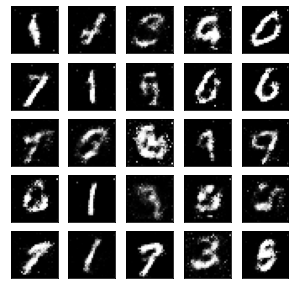

Epoch[129/200],d_loss:0.941488,g_loss:0.828580 D real: 0.590063,D fake: 0.147378
Epoch[129/200],d_loss:0.944121,g_loss:0.830540 D real: 0.582953,D fake: 0.149576
Epoch[129/200],d_loss:0.798059,g_loss:0.811998 D real: 0.729686,D fake: 0.146898
Epoch[129/200],d_loss:0.731580,g_loss:0.785308 D real: 0.728095,D fake: 0.173287


 65%|██████▌   | 130/200 [1:14:18<39:51, 34.17s/it]

Epoch[130/200],d_loss:0.761789,g_loss:0.748016 D real: 0.718580,D fake: 0.198932
Epoch[130/200],d_loss:0.743832,g_loss:0.817345 D real: 0.731912,D fake: 0.149894
Epoch[130/200],d_loss:0.841243,g_loss:0.725341 D real: 0.726891,D fake: 0.220141
Epoch[130/200],d_loss:0.737753,g_loss:0.767920 D real: 0.753954,D fake: 0.186019


 66%|██████▌   | 131/200 [1:14:50<38:46, 33.71s/it]

Epoch[131/200],d_loss:0.879992,g_loss:0.804845 D real: 0.665550,D fake: 0.161394
Epoch[131/200],d_loss:0.724859,g_loss:0.760572 D real: 0.678826,D fake: 0.192344
Epoch[131/200],d_loss:0.813056,g_loss:0.741145 D real: 0.764720,D fake: 0.201258
Epoch[131/200],d_loss:0.749914,g_loss:0.848200 D real: 0.739716,D fake: 0.123367


 66%|██████▌   | 132/200 [1:15:22<37:35, 33.18s/it]

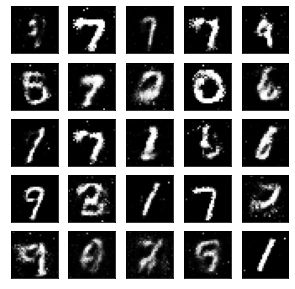

Epoch[132/200],d_loss:0.787339,g_loss:0.810802 D real: 0.677817,D fake: 0.142640
Epoch[132/200],d_loss:1.003109,g_loss:0.541746 D real: 0.691590,D fake: 0.328437
Epoch[132/200],d_loss:0.765212,g_loss:0.834149 D real: 0.705144,D fake: 0.133066
Epoch[132/200],d_loss:0.767156,g_loss:0.864784 D real: 0.704662,D fake: 0.114905


 66%|██████▋   | 133/200 [1:15:57<37:44, 33.79s/it]

Epoch[133/200],d_loss:0.709946,g_loss:0.819302 D real: 0.744179,D fake: 0.141746
Epoch[133/200],d_loss:0.829515,g_loss:0.827501 D real: 0.748845,D fake: 0.145751
Epoch[133/200],d_loss:0.731625,g_loss:0.640266 D real: 0.817326,D fake: 0.267486
Epoch[133/200],d_loss:0.729873,g_loss:0.740092 D real: 0.729453,D fake: 0.200179


 67%|██████▋   | 134/200 [1:16:30<36:41, 33.36s/it]

Epoch[134/200],d_loss:0.763716,g_loss:0.769383 D real: 0.730586,D fake: 0.182592
Epoch[134/200],d_loss:0.694362,g_loss:0.817814 D real: 0.755250,D fake: 0.156749
Epoch[134/200],d_loss:0.844787,g_loss:0.709576 D real: 0.688254,D fake: 0.224139
Epoch[134/200],d_loss:0.868907,g_loss:0.778804 D real: 0.641832,D fake: 0.174506


 68%|██████▊   | 135/200 [1:17:04<36:18, 33.51s/it]

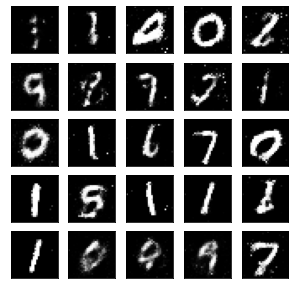

Epoch[135/200],d_loss:0.844275,g_loss:0.767549 D real: 0.698082,D fake: 0.171078
Epoch[135/200],d_loss:0.646596,g_loss:0.815948 D real: 0.839530,D fake: 0.144403
Epoch[135/200],d_loss:0.705195,g_loss:0.774485 D real: 0.747302,D fake: 0.173557
Epoch[135/200],d_loss:0.835946,g_loss:0.755782 D real: 0.796638,D fake: 0.193668


 68%|██████▊   | 136/200 [1:17:41<36:54, 34.59s/it]

Epoch[136/200],d_loss:0.766506,g_loss:0.781845 D real: 0.754141,D fake: 0.179389
Epoch[136/200],d_loss:0.767312,g_loss:0.896741 D real: 0.714453,D fake: 0.091800
Epoch[136/200],d_loss:0.740110,g_loss:0.682817 D real: 0.745718,D fake: 0.223654
Epoch[136/200],d_loss:0.888316,g_loss:0.652228 D real: 0.652485,D fake: 0.246098


 68%|██████▊   | 137/200 [1:18:14<36:02, 34.33s/it]

Epoch[137/200],d_loss:0.828880,g_loss:0.705120 D real: 0.671883,D fake: 0.225172
Epoch[137/200],d_loss:0.892791,g_loss:0.788108 D real: 0.651464,D fake: 0.173485
Epoch[137/200],d_loss:0.885029,g_loss:0.616970 D real: 0.747304,D fake: 0.270848
Epoch[137/200],d_loss:0.790042,g_loss:0.768205 D real: 0.691846,D fake: 0.190283


 69%|██████▉   | 138/200 [1:18:49<35:41, 34.54s/it]

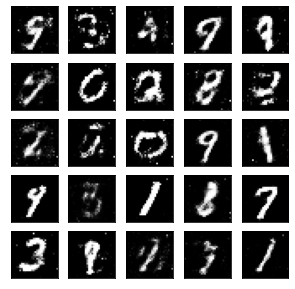

Epoch[138/200],d_loss:0.779832,g_loss:0.838934 D real: 0.677817,D fake: 0.134711
Epoch[138/200],d_loss:0.810284,g_loss:0.733189 D real: 0.744451,D fake: 0.211568
Epoch[138/200],d_loss:0.911792,g_loss:0.666621 D real: 0.680382,D fake: 0.253883
Epoch[138/200],d_loss:1.000065,g_loss:0.684604 D real: 0.656044,D fake: 0.240107


 70%|██████▉   | 139/200 [1:19:29<36:34, 35.98s/it]

Epoch[139/200],d_loss:0.779039,g_loss:0.815224 D real: 0.656199,D fake: 0.151567
Epoch[139/200],d_loss:0.854659,g_loss:0.639732 D real: 0.804121,D fake: 0.265536
Epoch[139/200],d_loss:0.740570,g_loss:0.798489 D real: 0.748936,D fake: 0.170044
Epoch[139/200],d_loss:0.667205,g_loss:0.832859 D real: 0.800912,D fake: 0.129865


 70%|███████   | 140/200 [1:20:06<36:22, 36.38s/it]

Epoch[140/200],d_loss:0.906756,g_loss:0.799064 D real: 0.601712,D fake: 0.169867
Epoch[140/200],d_loss:0.757002,g_loss:0.725868 D real: 0.701382,D fake: 0.216203
Epoch[140/200],d_loss:0.882052,g_loss:0.798182 D real: 0.669815,D fake: 0.168661
Epoch[140/200],d_loss:1.081824,g_loss:0.563734 D real: 0.644165,D fake: 0.306058


 70%|███████   | 141/200 [1:20:44<36:14, 36.85s/it]

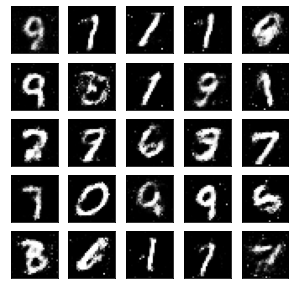

Epoch[141/200],d_loss:0.892106,g_loss:0.697687 D real: 0.734087,D fake: 0.235847
Epoch[141/200],d_loss:0.736909,g_loss:0.770169 D real: 0.745248,D fake: 0.180342
Epoch[141/200],d_loss:0.786155,g_loss:0.745510 D real: 0.749462,D fake: 0.198891
Epoch[141/200],d_loss:0.818831,g_loss:0.725574 D real: 0.722017,D fake: 0.210758


 71%|███████   | 142/200 [1:21:23<36:09, 37.40s/it]

Epoch[142/200],d_loss:0.673581,g_loss:0.857011 D real: 0.706151,D fake: 0.118646
Epoch[142/200],d_loss:0.618466,g_loss:0.906620 D real: 0.772698,D fake: 0.079482
Epoch[142/200],d_loss:0.967657,g_loss:0.696896 D real: 0.660834,D fake: 0.228842
Epoch[142/200],d_loss:0.923063,g_loss:0.600983 D real: 0.748034,D fake: 0.296566


 72%|███████▏  | 143/200 [1:21:58<34:55, 36.77s/it]

Epoch[143/200],d_loss:0.713787,g_loss:0.829603 D real: 0.794216,D fake: 0.140620
Epoch[143/200],d_loss:0.941049,g_loss:0.750618 D real: 0.622098,D fake: 0.194678
Epoch[143/200],d_loss:0.738791,g_loss:0.804039 D real: 0.733066,D fake: 0.158216
Epoch[143/200],d_loss:0.728395,g_loss:0.789354 D real: 0.686849,D fake: 0.159866


 72%|███████▏  | 144/200 [1:22:30<32:55, 35.28s/it]

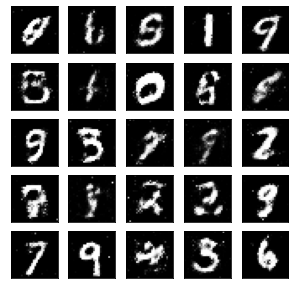

Epoch[144/200],d_loss:0.983574,g_loss:0.545984 D real: 0.741139,D fake: 0.323125
Epoch[144/200],d_loss:0.826850,g_loss:0.823848 D real: 0.662892,D fake: 0.147933
Epoch[144/200],d_loss:0.768458,g_loss:0.742767 D real: 0.694909,D fake: 0.204296
Epoch[144/200],d_loss:0.723074,g_loss:0.877351 D real: 0.741401,D fake: 0.103599


 72%|███████▎  | 145/200 [1:23:08<33:02, 36.04s/it]

Epoch[145/200],d_loss:0.927002,g_loss:0.761769 D real: 0.635879,D fake: 0.192683
Epoch[145/200],d_loss:0.745531,g_loss:0.720320 D real: 0.761070,D fake: 0.219321
Epoch[145/200],d_loss:0.685869,g_loss:0.824630 D real: 0.719792,D fake: 0.144086
Epoch[145/200],d_loss:0.805683,g_loss:0.758246 D real: 0.751113,D fake: 0.183773


 73%|███████▎  | 146/200 [1:23:43<32:12, 35.78s/it]

Epoch[146/200],d_loss:1.031703,g_loss:0.651343 D real: 0.562747,D fake: 0.261369
Epoch[146/200],d_loss:0.968009,g_loss:0.669846 D real: 0.641301,D fake: 0.254657
Epoch[146/200],d_loss:0.714758,g_loss:0.775527 D real: 0.778106,D fake: 0.179870
Epoch[146/200],d_loss:0.781992,g_loss:0.778731 D real: 0.707412,D fake: 0.185432


 74%|███████▎  | 147/200 [1:24:17<31:13, 35.35s/it]

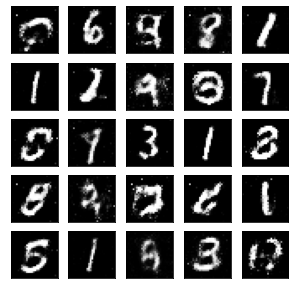

Epoch[147/200],d_loss:0.804612,g_loss:0.742382 D real: 0.733869,D fake: 0.201913
Epoch[147/200],d_loss:0.799400,g_loss:0.819520 D real: 0.703221,D fake: 0.146790
Epoch[147/200],d_loss:0.760700,g_loss:0.799541 D real: 0.681969,D fake: 0.167257
Epoch[147/200],d_loss:0.820833,g_loss:0.762936 D real: 0.660100,D fake: 0.181931


 74%|███████▍  | 148/200 [1:24:53<30:37, 35.34s/it]

Epoch[148/200],d_loss:0.883420,g_loss:0.723522 D real: 0.703049,D fake: 0.215201
Epoch[148/200],d_loss:0.838421,g_loss:0.730465 D real: 0.746255,D fake: 0.211606
Epoch[148/200],d_loss:0.753958,g_loss:0.798284 D real: 0.691348,D fake: 0.161998
Epoch[148/200],d_loss:0.689969,g_loss:0.727231 D real: 0.741767,D fake: 0.202969


 74%|███████▍  | 149/200 [1:25:27<29:43, 34.97s/it]

Epoch[149/200],d_loss:0.790637,g_loss:0.781428 D real: 0.742859,D fake: 0.171839
Epoch[149/200],d_loss:0.778504,g_loss:0.779490 D real: 0.668287,D fake: 0.179331
Epoch[149/200],d_loss:0.813522,g_loss:0.712126 D real: 0.676268,D fake: 0.211226
Epoch[149/200],d_loss:0.630482,g_loss:0.866047 D real: 0.762155,D fake: 0.114153


 75%|███████▌  | 150/200 [1:25:59<28:26, 34.14s/it]

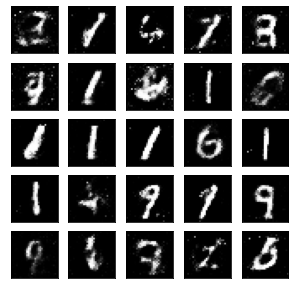

Epoch[150/200],d_loss:0.827182,g_loss:0.718769 D real: 0.749667,D fake: 0.222966
Epoch[150/200],d_loss:0.779262,g_loss:0.779189 D real: 0.688776,D fake: 0.175024
Epoch[150/200],d_loss:0.758576,g_loss:0.669528 D real: 0.695482,D fake: 0.247319
Epoch[150/200],d_loss:0.836073,g_loss:0.843298 D real: 0.650345,D fake: 0.132980


 76%|███████▌  | 151/200 [1:26:33<27:59, 34.28s/it]

Epoch[151/200],d_loss:0.735175,g_loss:0.869219 D real: 0.684318,D fake: 0.113205
Epoch[151/200],d_loss:0.721986,g_loss:0.862390 D real: 0.780475,D fake: 0.118830
Epoch[151/200],d_loss:0.989275,g_loss:0.630045 D real: 0.748491,D fake: 0.280018
Epoch[151/200],d_loss:0.720667,g_loss:0.833349 D real: 0.722797,D fake: 0.136795


 76%|███████▌  | 152/200 [1:27:05<26:52, 33.60s/it]

Epoch[152/200],d_loss:0.688426,g_loss:0.781447 D real: 0.778155,D fake: 0.163899
Epoch[152/200],d_loss:0.787345,g_loss:0.747651 D real: 0.769161,D fake: 0.187451
Epoch[152/200],d_loss:1.079084,g_loss:0.614292 D real: 0.599941,D fake: 0.292225
Epoch[152/200],d_loss:0.918957,g_loss:0.622888 D real: 0.779183,D fake: 0.283200


 76%|███████▋  | 153/200 [1:27:44<27:27, 35.05s/it]

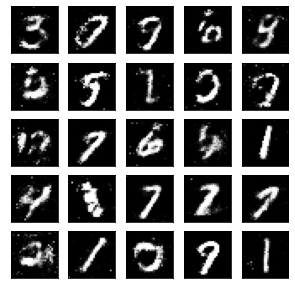

Epoch[153/200],d_loss:0.697891,g_loss:0.818332 D real: 0.733618,D fake: 0.147088
Epoch[153/200],d_loss:0.821923,g_loss:0.694657 D real: 0.735956,D fake: 0.236951
Epoch[153/200],d_loss:0.822919,g_loss:0.816071 D real: 0.661572,D fake: 0.153730
Epoch[153/200],d_loss:0.841876,g_loss:0.804461 D real: 0.665986,D fake: 0.160135


 77%|███████▋  | 154/200 [1:28:18<26:32, 34.63s/it]

Epoch[154/200],d_loss:0.695495,g_loss:0.828252 D real: 0.770455,D fake: 0.137956
Epoch[154/200],d_loss:0.806564,g_loss:0.740438 D real: 0.700382,D fake: 0.211376
Epoch[154/200],d_loss:0.962808,g_loss:0.677788 D real: 0.602962,D fake: 0.249955
Epoch[154/200],d_loss:0.913914,g_loss:0.742903 D real: 0.662455,D fake: 0.205809


 78%|███████▊  | 155/200 [1:28:50<25:28, 33.97s/it]

Epoch[155/200],d_loss:0.789239,g_loss:0.795111 D real: 0.711955,D fake: 0.159865
Epoch[155/200],d_loss:0.795060,g_loss:0.749859 D real: 0.719259,D fake: 0.197042
Epoch[155/200],d_loss:0.887638,g_loss:0.781832 D real: 0.760791,D fake: 0.178534
Epoch[155/200],d_loss:0.869519,g_loss:0.794969 D real: 0.698187,D fake: 0.169467


 78%|███████▊  | 156/200 [1:29:24<24:50, 33.88s/it]

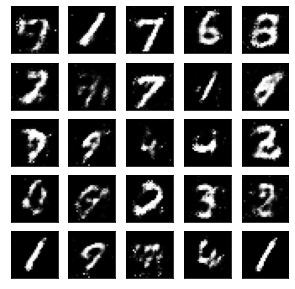

Epoch[156/200],d_loss:0.787485,g_loss:0.803222 D real: 0.791966,D fake: 0.161176
Epoch[156/200],d_loss:0.766905,g_loss:0.785597 D real: 0.710894,D fake: 0.172894
Epoch[156/200],d_loss:0.810372,g_loss:0.815836 D real: 0.668645,D fake: 0.146728
Epoch[156/200],d_loss:0.853372,g_loss:0.772367 D real: 0.739163,D fake: 0.180927


 78%|███████▊  | 157/200 [1:30:02<25:10, 35.13s/it]

Epoch[157/200],d_loss:0.903930,g_loss:0.784606 D real: 0.607291,D fake: 0.175872
Epoch[157/200],d_loss:0.877133,g_loss:0.794092 D real: 0.690019,D fake: 0.167835
Epoch[157/200],d_loss:0.954707,g_loss:0.741618 D real: 0.690632,D fake: 0.204779
Epoch[157/200],d_loss:1.001944,g_loss:0.648267 D real: 0.576222,D fake: 0.271336


 79%|███████▉  | 158/200 [1:30:37<24:36, 35.16s/it]

Epoch[158/200],d_loss:0.831860,g_loss:0.737676 D real: 0.669190,D fake: 0.200594
Epoch[158/200],d_loss:0.871890,g_loss:0.703566 D real: 0.731408,D fake: 0.230336
Epoch[158/200],d_loss:0.609555,g_loss:0.944837 D real: 0.762920,D fake: 0.050408
Epoch[158/200],d_loss:0.824374,g_loss:0.725903 D real: 0.749293,D fake: 0.215011


 80%|███████▉  | 159/200 [1:31:10<23:34, 34.50s/it]

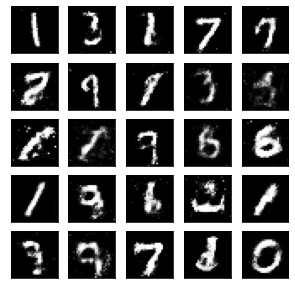

Epoch[159/200],d_loss:0.786575,g_loss:0.781582 D real: 0.726368,D fake: 0.165700
Epoch[159/200],d_loss:0.923978,g_loss:0.794668 D real: 0.622155,D fake: 0.167150
Epoch[159/200],d_loss:0.766075,g_loss:0.661423 D real: 0.746683,D fake: 0.245414
Epoch[159/200],d_loss:0.892478,g_loss:0.712194 D real: 0.659652,D fake: 0.210682


 80%|████████  | 160/200 [1:31:46<23:22, 35.07s/it]

Epoch[160/200],d_loss:0.691951,g_loss:0.748877 D real: 0.754719,D fake: 0.188806
Epoch[160/200],d_loss:0.805538,g_loss:0.781666 D real: 0.681730,D fake: 0.172982
Epoch[160/200],d_loss:0.811939,g_loss:0.685726 D real: 0.711946,D fake: 0.240934
Epoch[160/200],d_loss:0.814432,g_loss:0.690711 D real: 0.661292,D fake: 0.217631


 80%|████████  | 161/200 [1:32:18<22:13, 34.19s/it]

Epoch[161/200],d_loss:0.719312,g_loss:0.827664 D real: 0.690638,D fake: 0.141529
Epoch[161/200],d_loss:0.799913,g_loss:0.738653 D real: 0.707410,D fake: 0.200001
Epoch[161/200],d_loss:0.915676,g_loss:0.819644 D real: 0.707251,D fake: 0.146313
Epoch[161/200],d_loss:0.815247,g_loss:0.779822 D real: 0.680895,D fake: 0.181894


 81%|████████  | 162/200 [1:32:51<21:26, 33.85s/it]

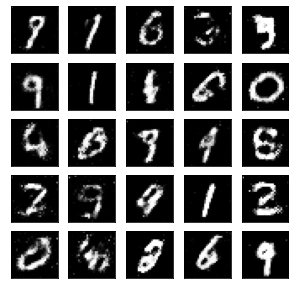

Epoch[162/200],d_loss:0.823047,g_loss:0.688552 D real: 0.658188,D fake: 0.244519
Epoch[162/200],d_loss:0.783820,g_loss:0.741413 D real: 0.758340,D fake: 0.202855
Epoch[162/200],d_loss:0.798311,g_loss:0.769418 D real: 0.723595,D fake: 0.177585
Epoch[162/200],d_loss:1.083380,g_loss:0.697969 D real: 0.602939,D fake: 0.238733


 82%|████████▏ | 163/200 [1:33:29<21:30, 34.89s/it]

Epoch[163/200],d_loss:0.836137,g_loss:0.744882 D real: 0.725997,D fake: 0.200138
Epoch[163/200],d_loss:0.825803,g_loss:0.770149 D real: 0.700097,D fake: 0.184903
Epoch[163/200],d_loss:0.823437,g_loss:0.806931 D real: 0.689555,D fake: 0.156633
Epoch[163/200],d_loss:0.832445,g_loss:0.672393 D real: 0.688981,D fake: 0.242606


 82%|████████▏ | 164/200 [1:34:04<21:04, 35.13s/it]

Epoch[164/200],d_loss:0.966962,g_loss:0.725010 D real: 0.601509,D fake: 0.219970
Epoch[164/200],d_loss:0.763117,g_loss:0.799831 D real: 0.688048,D fake: 0.160912
Epoch[164/200],d_loss:0.885911,g_loss:0.740673 D real: 0.719359,D fake: 0.207268
Epoch[164/200],d_loss:1.047598,g_loss:0.598715 D real: 0.618243,D fake: 0.290062


 82%|████████▎ | 165/200 [1:34:41<20:39, 35.41s/it]

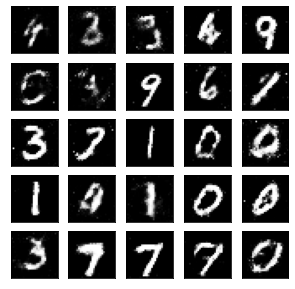

Epoch[165/200],d_loss:0.787098,g_loss:0.727415 D real: 0.699751,D fake: 0.215087
Epoch[165/200],d_loss:0.690318,g_loss:0.798605 D real: 0.735772,D fake: 0.164049
Epoch[165/200],d_loss:0.776617,g_loss:0.806131 D real: 0.692539,D fake: 0.162644
Epoch[165/200],d_loss:0.841580,g_loss:0.716220 D real: 0.695367,D fake: 0.217878


 83%|████████▎ | 166/200 [1:35:17<20:19, 35.87s/it]

Epoch[166/200],d_loss:0.832792,g_loss:0.670330 D real: 0.713082,D fake: 0.244069
Epoch[166/200],d_loss:0.864293,g_loss:0.756037 D real: 0.634960,D fake: 0.195335
Epoch[166/200],d_loss:0.799457,g_loss:0.774013 D real: 0.719365,D fake: 0.182320
Epoch[166/200],d_loss:0.777078,g_loss:0.810467 D real: 0.712281,D fake: 0.157561


 84%|████████▎ | 167/200 [1:35:50<19:10, 34.88s/it]

Epoch[167/200],d_loss:0.766007,g_loss:0.819587 D real: 0.726378,D fake: 0.149619
Epoch[167/200],d_loss:0.737233,g_loss:0.619334 D real: 0.704046,D fake: 0.263875
Epoch[167/200],d_loss:0.773849,g_loss:0.761954 D real: 0.757004,D fake: 0.194531
Epoch[167/200],d_loss:0.729931,g_loss:0.797074 D real: 0.718840,D fake: 0.163395


 84%|████████▍ | 168/200 [1:36:28<19:01, 35.68s/it]

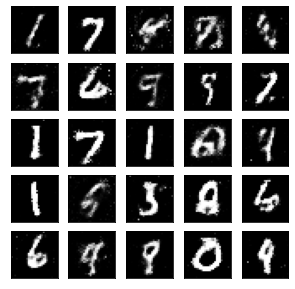

Epoch[168/200],d_loss:0.973920,g_loss:0.554704 D real: 0.637693,D fake: 0.315633
Epoch[168/200],d_loss:0.873780,g_loss:0.672002 D real: 0.716937,D fake: 0.241986
Epoch[168/200],d_loss:0.736986,g_loss:0.733323 D real: 0.770652,D fake: 0.199449
Epoch[168/200],d_loss:0.819542,g_loss:0.845540 D real: 0.751204,D fake: 0.129734


 84%|████████▍ | 169/200 [1:37:06<18:46, 36.35s/it]

Epoch[169/200],d_loss:0.854169,g_loss:0.701801 D real: 0.682715,D fake: 0.228985
Epoch[169/200],d_loss:0.864399,g_loss:0.707161 D real: 0.720338,D fake: 0.225234
Epoch[169/200],d_loss:1.037998,g_loss:0.823509 D real: 0.688078,D fake: 0.148976
Epoch[169/200],d_loss:0.868391,g_loss:0.673421 D real: 0.746316,D fake: 0.251226


 85%|████████▌ | 170/200 [1:37:40<17:57, 35.92s/it]

Epoch[170/200],d_loss:0.901147,g_loss:0.736420 D real: 0.712962,D fake: 0.205765
Epoch[170/200],d_loss:0.958004,g_loss:0.649778 D real: 0.629279,D fake: 0.260086
Epoch[170/200],d_loss:0.928022,g_loss:0.661023 D real: 0.686823,D fake: 0.264418
Epoch[170/200],d_loss:0.768706,g_loss:0.702146 D real: 0.722285,D fake: 0.216437


 86%|████████▌ | 171/200 [1:38:19<17:43, 36.67s/it]

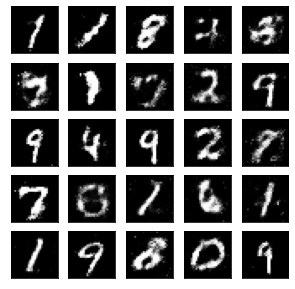

Epoch[171/200],d_loss:0.915882,g_loss:0.782430 D real: 0.634428,D fake: 0.177458
Epoch[171/200],d_loss:0.884435,g_loss:0.604556 D real: 0.743660,D fake: 0.292198
Epoch[171/200],d_loss:0.789722,g_loss:0.742809 D real: 0.707698,D fake: 0.200512
Epoch[171/200],d_loss:0.865373,g_loss:0.690243 D real: 0.668574,D fake: 0.230625


 86%|████████▌ | 172/200 [1:38:59<17:32, 37.57s/it]

Epoch[172/200],d_loss:0.707277,g_loss:0.868610 D real: 0.710461,D fake: 0.113578
Epoch[172/200],d_loss:0.804141,g_loss:0.770961 D real: 0.678043,D fake: 0.181695
Epoch[172/200],d_loss:0.817844,g_loss:0.851317 D real: 0.694527,D fake: 0.120134
Epoch[172/200],d_loss:0.770746,g_loss:0.801840 D real: 0.768968,D fake: 0.160590


 86%|████████▋ | 173/200 [1:39:32<16:22, 36.39s/it]

Epoch[173/200],d_loss:0.873603,g_loss:0.803224 D real: 0.768206,D fake: 0.160944
Epoch[173/200],d_loss:0.882747,g_loss:0.655967 D real: 0.704273,D fake: 0.256819
Epoch[173/200],d_loss:0.931474,g_loss:0.791667 D real: 0.701842,D fake: 0.167062
Epoch[173/200],d_loss:0.811576,g_loss:0.617871 D real: 0.738239,D fake: 0.276146


 87%|████████▋ | 174/200 [1:40:06<15:29, 35.73s/it]

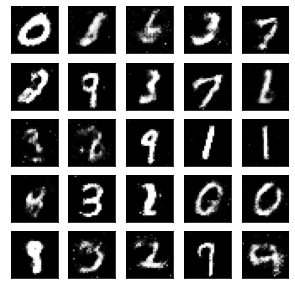

Epoch[174/200],d_loss:0.783443,g_loss:0.786232 D real: 0.761388,D fake: 0.175085
Epoch[174/200],d_loss:0.971645,g_loss:0.692859 D real: 0.617827,D fake: 0.237139
Epoch[174/200],d_loss:0.900933,g_loss:0.615567 D real: 0.598835,D fake: 0.274960
Epoch[174/200],d_loss:0.810410,g_loss:0.684986 D real: 0.724890,D fake: 0.233842


 88%|████████▊ | 175/200 [1:40:45<15:15, 36.60s/it]

Epoch[175/200],d_loss:0.958723,g_loss:0.602878 D real: 0.694709,D fake: 0.291566
Epoch[175/200],d_loss:0.927360,g_loss:0.670785 D real: 0.668954,D fake: 0.253631
Epoch[175/200],d_loss:0.784127,g_loss:0.716352 D real: 0.716755,D fake: 0.212164
Epoch[175/200],d_loss:0.806228,g_loss:0.740363 D real: 0.705662,D fake: 0.195518


 88%|████████▊ | 176/200 [1:41:22<14:38, 36.60s/it]

Epoch[176/200],d_loss:0.914445,g_loss:0.598276 D real: 0.652467,D fake: 0.288136
Epoch[176/200],d_loss:1.035467,g_loss:0.754347 D real: 0.562438,D fake: 0.198561
Epoch[176/200],d_loss:0.901716,g_loss:0.742916 D real: 0.628452,D fake: 0.204688
Epoch[176/200],d_loss:1.056056,g_loss:0.659717 D real: 0.599422,D fake: 0.249194


 88%|████████▊ | 177/200 [1:41:58<14:01, 36.60s/it]

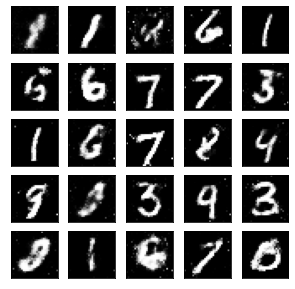

Epoch[177/200],d_loss:0.846458,g_loss:0.554821 D real: 0.693604,D fake: 0.318197
Epoch[177/200],d_loss:0.896277,g_loss:0.722079 D real: 0.595406,D fake: 0.210959
Epoch[177/200],d_loss:0.920962,g_loss:0.672015 D real: 0.680341,D fake: 0.245959
Epoch[177/200],d_loss:0.837438,g_loss:0.685411 D real: 0.680906,D fake: 0.239424


 89%|████████▉ | 178/200 [1:42:34<13:17, 36.24s/it]

Epoch[178/200],d_loss:1.026676,g_loss:0.594156 D real: 0.675716,D fake: 0.297005
Epoch[178/200],d_loss:1.046982,g_loss:0.675637 D real: 0.651820,D fake: 0.246625
Epoch[178/200],d_loss:0.863060,g_loss:0.739799 D real: 0.693313,D fake: 0.207547
Epoch[178/200],d_loss:0.824498,g_loss:0.804064 D real: 0.686723,D fake: 0.157796


 90%|████████▉ | 179/200 [1:43:12<12:57, 37.03s/it]

Epoch[179/200],d_loss:0.868806,g_loss:0.769939 D real: 0.726999,D fake: 0.183752
Epoch[179/200],d_loss:0.855050,g_loss:0.740419 D real: 0.661937,D fake: 0.202031
Epoch[179/200],d_loss:0.907029,g_loss:0.804826 D real: 0.689489,D fake: 0.157182
Epoch[179/200],d_loss:0.787736,g_loss:0.779055 D real: 0.786183,D fake: 0.178863


 90%|█████████ | 180/200 [1:43:46<12:02, 36.11s/it]

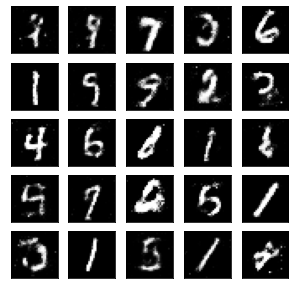

Epoch[180/200],d_loss:0.893825,g_loss:0.617884 D real: 0.660686,D fake: 0.270248
Epoch[180/200],d_loss:0.851204,g_loss:0.754783 D real: 0.665081,D fake: 0.195733
Epoch[180/200],d_loss:0.920806,g_loss:0.611224 D real: 0.682442,D fake: 0.271383
Epoch[180/200],d_loss:0.927740,g_loss:0.729371 D real: 0.670259,D fake: 0.219462


 90%|█████████ | 181/200 [1:44:26<11:44, 37.10s/it]

Epoch[181/200],d_loss:0.966445,g_loss:0.750987 D real: 0.633875,D fake: 0.196562
Epoch[181/200],d_loss:0.903906,g_loss:0.635466 D real: 0.698852,D fake: 0.272764
Epoch[181/200],d_loss:0.907879,g_loss:0.637557 D real: 0.684674,D fake: 0.265310
Epoch[181/200],d_loss:0.877270,g_loss:0.698843 D real: 0.686359,D fake: 0.226221


 91%|█████████ | 182/200 [1:45:00<10:52, 36.26s/it]

Epoch[182/200],d_loss:0.846092,g_loss:0.658239 D real: 0.680668,D fake: 0.250627
Epoch[182/200],d_loss:0.875535,g_loss:0.655398 D real: 0.785442,D fake: 0.259501
Epoch[182/200],d_loss:0.951786,g_loss:0.778084 D real: 0.589488,D fake: 0.180396
Epoch[182/200],d_loss:1.010463,g_loss:0.693367 D real: 0.668374,D fake: 0.236634


 92%|█████████▏| 183/200 [1:45:35<10:11, 35.97s/it]

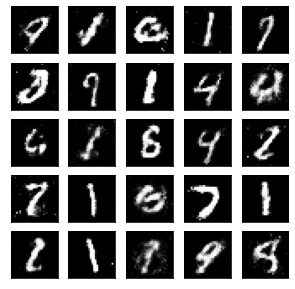

Epoch[183/200],d_loss:0.986249,g_loss:0.595927 D real: 0.608882,D fake: 0.304986
Epoch[183/200],d_loss:0.964954,g_loss:0.515359 D real: 0.693572,D fake: 0.339822
Epoch[183/200],d_loss:0.899628,g_loss:0.627030 D real: 0.619570,D fake: 0.280114
Epoch[183/200],d_loss:0.879966,g_loss:0.657181 D real: 0.693022,D fake: 0.258496


 92%|█████████▏| 184/200 [1:46:11<09:31, 35.72s/it]

Epoch[184/200],d_loss:0.950403,g_loss:0.560471 D real: 0.682554,D fake: 0.305603
Epoch[184/200],d_loss:1.080249,g_loss:0.509037 D real: 0.687496,D fake: 0.344922
Epoch[184/200],d_loss:0.863620,g_loss:0.700396 D real: 0.671994,D fake: 0.236786
Epoch[184/200],d_loss:0.869402,g_loss:0.791443 D real: 0.782269,D fake: 0.162719


 92%|█████████▎| 185/200 [1:46:48<09:05, 36.34s/it]

Epoch[185/200],d_loss:0.937291,g_loss:0.786790 D real: 0.596187,D fake: 0.175643
Epoch[185/200],d_loss:0.872078,g_loss:0.769770 D real: 0.655361,D fake: 0.177215
Epoch[185/200],d_loss:0.891982,g_loss:0.737187 D real: 0.708916,D fake: 0.211068
Epoch[185/200],d_loss:0.907015,g_loss:0.661490 D real: 0.739742,D fake: 0.259798


 93%|█████████▎| 186/200 [1:47:22<08:18, 35.60s/it]

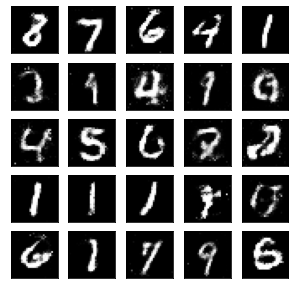

Epoch[186/200],d_loss:0.809415,g_loss:0.786485 D real: 0.708199,D fake: 0.170179
Epoch[186/200],d_loss:0.857672,g_loss:0.699074 D real: 0.646989,D fake: 0.228958
Epoch[186/200],d_loss:0.908828,g_loss:0.656768 D real: 0.670870,D fake: 0.246911
Epoch[186/200],d_loss:0.904165,g_loss:0.695138 D real: 0.669832,D fake: 0.232148


 94%|█████████▎| 187/200 [1:47:58<07:43, 35.68s/it]

Epoch[187/200],d_loss:0.857633,g_loss:0.663333 D real: 0.652473,D fake: 0.254458
Epoch[187/200],d_loss:0.761959,g_loss:0.807510 D real: 0.743102,D fake: 0.159174
Epoch[187/200],d_loss:0.794292,g_loss:0.701968 D real: 0.712238,D fake: 0.224306
Epoch[187/200],d_loss:1.002730,g_loss:0.728594 D real: 0.591067,D fake: 0.210988


 94%|█████████▍| 188/200 [1:48:35<07:13, 36.11s/it]

Epoch[188/200],d_loss:0.919393,g_loss:0.763723 D real: 0.710726,D fake: 0.186381
Epoch[188/200],d_loss:0.815364,g_loss:0.766659 D real: 0.637270,D fake: 0.185197
Epoch[188/200],d_loss:0.866017,g_loss:0.661685 D real: 0.705298,D fake: 0.247667
Epoch[188/200],d_loss:0.900489,g_loss:0.722470 D real: 0.645253,D fake: 0.213164


 94%|█████████▍| 189/200 [1:49:12<06:39, 36.31s/it]

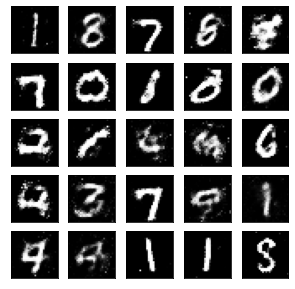

Epoch[189/200],d_loss:1.043843,g_loss:0.708512 D real: 0.606532,D fake: 0.224786
Epoch[189/200],d_loss:0.923462,g_loss:0.711848 D real: 0.655331,D fake: 0.226821
Epoch[189/200],d_loss:0.814701,g_loss:0.784887 D real: 0.708105,D fake: 0.172566
Epoch[189/200],d_loss:0.929458,g_loss:0.785644 D real: 0.623734,D fake: 0.178326


 95%|█████████▌| 190/200 [1:49:52<06:13, 37.40s/it]

Epoch[190/200],d_loss:0.887014,g_loss:0.748679 D real: 0.631301,D fake: 0.202577
Epoch[190/200],d_loss:0.879030,g_loss:0.734312 D real: 0.658210,D fake: 0.204917
Epoch[190/200],d_loss:0.793821,g_loss:0.753281 D real: 0.696461,D fake: 0.192301
Epoch[190/200],d_loss:0.815714,g_loss:0.628063 D real: 0.750566,D fake: 0.274296


 96%|█████████▌| 191/200 [1:50:28<05:32, 36.97s/it]

Epoch[191/200],d_loss:0.952150,g_loss:0.636604 D real: 0.607983,D fake: 0.258621
Epoch[191/200],d_loss:0.873634,g_loss:0.700128 D real: 0.686911,D fake: 0.231238
Epoch[191/200],d_loss:0.901003,g_loss:0.627766 D real: 0.664670,D fake: 0.266036
Epoch[191/200],d_loss:0.913801,g_loss:0.735033 D real: 0.708868,D fake: 0.207684


 96%|█████████▌| 192/200 [1:51:03<04:50, 36.28s/it]

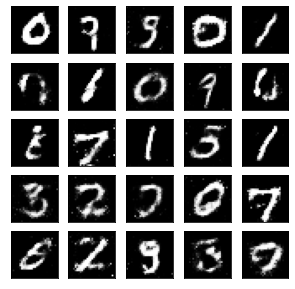

Epoch[192/200],d_loss:0.909808,g_loss:0.697323 D real: 0.661774,D fake: 0.232863
Epoch[192/200],d_loss:0.853470,g_loss:0.673747 D real: 0.743807,D fake: 0.235990
Epoch[192/200],d_loss:0.793197,g_loss:0.755102 D real: 0.667992,D fake: 0.194327
Epoch[192/200],d_loss:0.955086,g_loss:0.700134 D real: 0.737430,D fake: 0.232167


 96%|█████████▋| 193/200 [1:51:38<04:12, 36.05s/it]

Epoch[193/200],d_loss:0.898908,g_loss:0.807523 D real: 0.624040,D fake: 0.159677
Epoch[193/200],d_loss:0.953648,g_loss:0.749102 D real: 0.621761,D fake: 0.197806
Epoch[193/200],d_loss:0.973548,g_loss:0.805902 D real: 0.564128,D fake: 0.157948
Epoch[193/200],d_loss:0.803783,g_loss:0.714690 D real: 0.753993,D fake: 0.221677


 97%|█████████▋| 194/200 [1:52:11<03:31, 35.20s/it]

Epoch[194/200],d_loss:0.793454,g_loss:0.672420 D real: 0.696342,D fake: 0.238184
Epoch[194/200],d_loss:0.952894,g_loss:0.686009 D real: 0.625078,D fake: 0.244854
Epoch[194/200],d_loss:0.908368,g_loss:0.748696 D real: 0.597529,D fake: 0.197351
Epoch[194/200],d_loss:1.041161,g_loss:0.640660 D real: 0.584550,D fake: 0.271380


 98%|█████████▊| 195/200 [1:52:49<03:00, 36.04s/it]

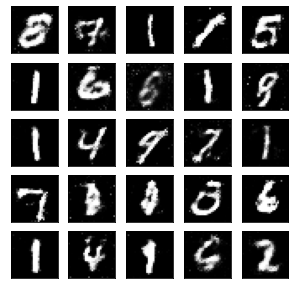

Epoch[195/200],d_loss:0.961680,g_loss:0.562016 D real: 0.681176,D fake: 0.306870
Epoch[195/200],d_loss:0.859357,g_loss:0.735651 D real: 0.679209,D fake: 0.209467
Epoch[195/200],d_loss:0.898796,g_loss:0.787790 D real: 0.727513,D fake: 0.166078
Epoch[195/200],d_loss:0.976389,g_loss:0.685047 D real: 0.597234,D fake: 0.236336


 98%|█████████▊| 196/200 [1:53:27<02:25, 36.40s/it]

Epoch[196/200],d_loss:0.912503,g_loss:0.707440 D real: 0.645846,D fake: 0.223122
Epoch[196/200],d_loss:0.927608,g_loss:0.725334 D real: 0.684910,D fake: 0.216510
Epoch[196/200],d_loss:0.830032,g_loss:0.626244 D real: 0.683591,D fake: 0.274637
Epoch[196/200],d_loss:0.748959,g_loss:0.779904 D real: 0.734163,D fake: 0.175926


 98%|█████████▊| 197/200 [1:54:05<01:50, 36.90s/it]

Epoch[197/200],d_loss:0.872859,g_loss:0.766333 D real: 0.656952,D fake: 0.185444
Epoch[197/200],d_loss:0.816279,g_loss:0.724273 D real: 0.689976,D fake: 0.212597
Epoch[197/200],d_loss:0.892708,g_loss:0.718101 D real: 0.650068,D fake: 0.223884
Epoch[197/200],d_loss:0.920750,g_loss:0.676695 D real: 0.646649,D fake: 0.244442


 99%|█████████▉| 198/200 [1:54:39<01:12, 36.14s/it]

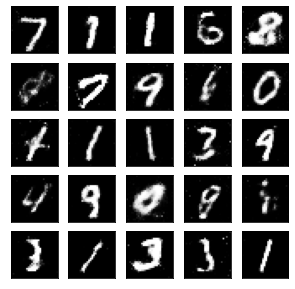

Epoch[198/200],d_loss:0.988363,g_loss:0.720323 D real: 0.579529,D fake: 0.212128
Epoch[198/200],d_loss:0.980944,g_loss:0.697356 D real: 0.558632,D fake: 0.231300
Epoch[198/200],d_loss:0.804557,g_loss:0.724891 D real: 0.682364,D fake: 0.207617
Epoch[198/200],d_loss:0.955465,g_loss:0.721487 D real: 0.729952,D fake: 0.206931


100%|█████████▉| 199/200 [1:55:14<00:35, 35.80s/it]

Epoch[199/200],d_loss:0.990485,g_loss:0.704379 D real: 0.746419,D fake: 0.230747
Epoch[199/200],d_loss:0.924673,g_loss:0.699127 D real: 0.609735,D fake: 0.229812
Epoch[199/200],d_loss:1.032651,g_loss:0.475236 D real: 0.770568,D fake: 0.363970
Epoch[199/200],d_loss:0.865511,g_loss:0.801687 D real: 0.640376,D fake: 0.162289


100%|██████████| 200/200 [1:55:53<00:00, 34.77s/it]


In [9]:
for epoch in tqdm(range(num_epoch)):
    if epoch % 3 == 0:
        G.eval()
        z = torch.randn(25, z_dimension).to(device)
        img = G(z)
        plt.close()
        grid_size, k = int(img.shape[0] ** 0.5), 0 # 10 * 10
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
        for i, j in product(range(grid_size), range(grid_size)): # to draw 10 * 10 images
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].imshow(img[k].data.view(28,28).cpu().numpy(), cmap='gray')
            k += 1
        plt.show()
    
    for i, (img, _) in enumerate(dataloader): # Since we don't need any labels, we make label be '_'

        # =============================== IMAGES =================================
        num_img = img.size(0) 
        img = img.view(num_img, -1) # view()函数作用是将一个多行的Tensor,拼接成一行
                                    # 第一个参数是要拼接的tensor,第二个参数是-1
        # After view(), the input image will be a vector as 28 * 28 = 782 dimensions
        real_img = img.to(device) # the sampled data are real images
        # =============================== LABELS =================================
        real_label = torch.ones(num_img).view(-1, 1).to(device) # Label of real images is 1
        fake_label = torch.zeros(num_img).view(-1, 1).to(device) # label of real images is 0
        
        # ========================= D: Forward and Loss ==========================
        
        real_out = D(real_img)
        d_loss_real = torch.mean((1-softlabel) * torch.log(real_out + 1e-8) + softlabel * torch.log(1 - real_out + 1e-8))
        
        z = torch.randn(num_img, z_dimension).to(device)
        fake_img = G(z)
        fake_out = D(fake_img)
        d_loss_fake = torch.mean(torch.log(1 - fake_out + 1e-8))
        # 1e-8 稳定训练，避免精度损失
        d_loss = -1 * (d_loss_real + d_loss_fake)
        d_optimizer.zero_grad() # before back propagation
        d_loss.backward()
        d_optimizer.step()
        
        # =============== G ========================
        # To fool the Discriminator, we want G's fake output can get 'real' pridection
        z = torch.randn(num_img, z_dimension).to(device)
        fake_img = G(z)
        fake_out = D(fake_img)
        # +1e-8以避免精度损失
        g_loss = 1 + torch.mean(torch.log(1 - fake_out + 1e-8))
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        # ============= Visualization ===============
        if (i+1)%100 == 0:
            print('Epoch[{}/{}],d_loss:{:.6f},g_loss:{:.6f} '
                  'D real: {:.6f},D fake: {:.6f}'.format(
                epoch,num_epoch,d_loss.item(),g_loss.item(),
                real_out.data.mean(),fake_out.data.mean()  #打印的是真实图片的损失均值
            ))
        
    '''if epoch == 0:
        real_images = to_gray_img(real_img.cpu().data)
        save_image(real_images, '../img/real_images.png')
 
    fake_images = to_gray_img(fake_img.cpu().data)
    save_image(fake_images, '../img/fake_images-{}.png'.format(epoch+1))'''

In [ ]:
torch.save(G.state_dict(),'./generator.pth')
torch.save(D.state_dict(),'./discriminator.pth')

# Debug 专区

In [10]:
print(real_out.size())

torch.Size([96, 1])


In [11]:
torch.save(G.state_dict(),'./generator.pth')
torch.save(D.state_dict(),'./discriminator.pth')